In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-inceptionresnetv2-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = InceptionResNetV2(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 224s 25ms/step - loss: 0.7340 - acc: 0.7858 - val_loss: 0.9780 - val_acc: 0.7178
Epoch 2/100
9112/9112 [==============================] - 147s 16ms/step - loss: 0.3936 - acc: 0.8833 - val_loss: 0.6402 - val_acc: 0.8486
Epoch 3/100
9112/9112 [==============================] - 146s 16ms/step - loss: 0.3003 - acc: 0.9078 - val_loss: 0.5769 - val_acc: 0.8330
Epoch 4/100
9125/9125 [==============================] - 147s 16ms/step - loss: 0.0168 - acc: 0.9950 - val_loss: 0.2381 - val_acc: 0.9614
Epoch 62/100
9125/9125 [==============================] - 147s 16ms/step - loss: 0.0032 - acc: 0.9992 - val_loss: 0.2560 - val_acc: 0.9594
Epoch 63/100
9125/9125 [==============================] - 147s 16ms/step - loss: 0.0023 - acc: 0.9992 - val_loss: 1.5870 - val_acc: 0.8338
Epoch 64/100
9125/9125 [==============================] - 147s 16ms/step - loss: 0.0410 - acc: 0.9866 - val_loss: 0.7536 -

9130/9130 [==============================] - 154s 17ms/step - loss: 0.0266 - acc: 0.9922 - val_loss: 5.1983 - val_acc: 0.5427
Epoch 59/100
9130/9130 [==============================] - 154s 17ms/step - loss: 0.0215 - acc: 0.9931 - val_loss: 1.0877 - val_acc: 0.8390
Epoch 60/100
9130/9130 [==============================] - 154s 17ms/step - loss: 0.0210 - acc: 0.9941 - val_loss: 0.2621 - val_acc: 0.9483
Epoch 61/100
9130/9130 [==============================] - 154s 17ms/step - loss: 0.0134 - acc: 0.9965 - val_loss: 0.3115 - val_acc: 0.9523
Epoch 62/100
9130/9130 [==============================] - 154s 17ms/step - loss: 0.0295 - acc: 0.9906 - val_loss: 0.7891 - val_acc: 0.8678
Epoch 63/100
9130/9130 [==============================] - 154s 17ms/step - loss: 0.0220 - acc: 0.9928 - val_loss: 0.4607 - val_acc: 0.9175
Epoch 64/100
9130/9130 [==============================] - 153s 17ms/step - loss: 0.0171 - acc: 0.9943 - val_loss: 1.0228 - val_acc: 0.8231
Epoch 65/100
9130/9130 [================

9132/9132 [==============================] - 152s 17ms/step - loss: 0.0876 - acc: 0.9712 - val_loss: 0.3752 - val_acc: 0.8825
Epoch 17/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0941 - acc: 0.9692 - val_loss: 0.4076 - val_acc: 0.9074
Epoch 18/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0808 - acc: 0.9727 - val_loss: 0.5007 - val_acc: 0.8556
Epoch 19/100
9132/9132 [==============================] - 152s 17ms/step - loss: 0.0685 - acc: 0.9770 - val_loss: 0.4331 - val_acc: 0.8944
Epoch 20/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0642 - acc: 0.9792 - val_loss: 0.5808 - val_acc: 0.8855
Epoch 21/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0675 - acc: 0.9768 - val_loss: 0.4911 - val_acc: 0.8954
Epoch 22/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0877 - acc: 0.9726 - val_loss: 0.5456 - val_acc: 0.8616
Epoch 23/100
9132/9132 [================

9132/9132 [==============================] - 151s 16ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.2324 - val_acc: 0.9582
Epoch 76/100
9132/9132 [==============================] - 150s 16ms/step - loss: 0.0037 - acc: 0.9986 - val_loss: 0.2511 - val_acc: 0.9572
Epoch 77/100
9132/9132 [==============================] - 151s 16ms/step - loss: 0.0087 - acc: 0.9975 - val_loss: 0.8470 - val_acc: 0.8536
Epoch 78/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0210 - acc: 0.9936 - val_loss: 0.8225 - val_acc: 0.8556
Epoch 79/100
9132/9132 [==============================] - 151s 17ms/step - loss: 0.0146 - acc: 0.9947 - val_loss: 0.2815 - val_acc: 0.9522
Epoch 80/100
9132/9132 [==============================] - 151s 16ms/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.7783 - val_acc: 0.8825
Epoch 81/100
9132/9132 [==============================] - 150s 16ms/step - loss: 0.0140 - acc: 0.9965 - val_loss: 1.6893 - val_acc: 0.7331
Epoch 82/100
9132/9132 [================

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9498


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

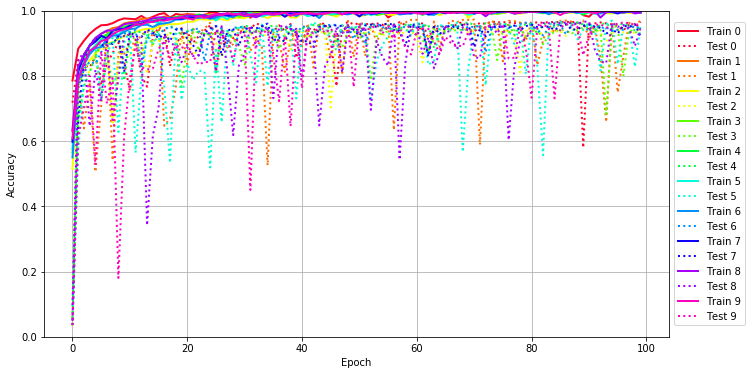

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

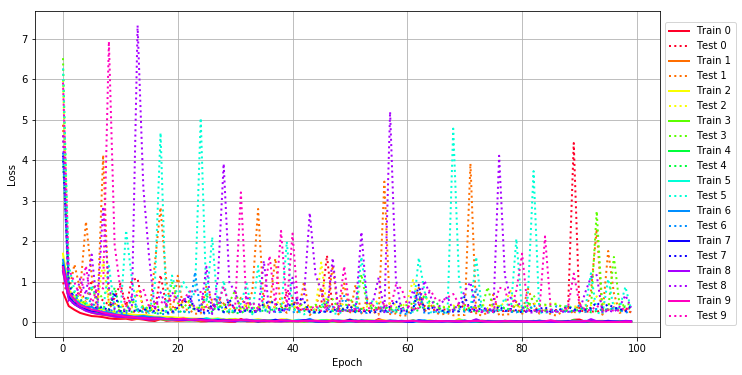

In [ ]:
plot_loss(history)

Plotting the confusion matrix


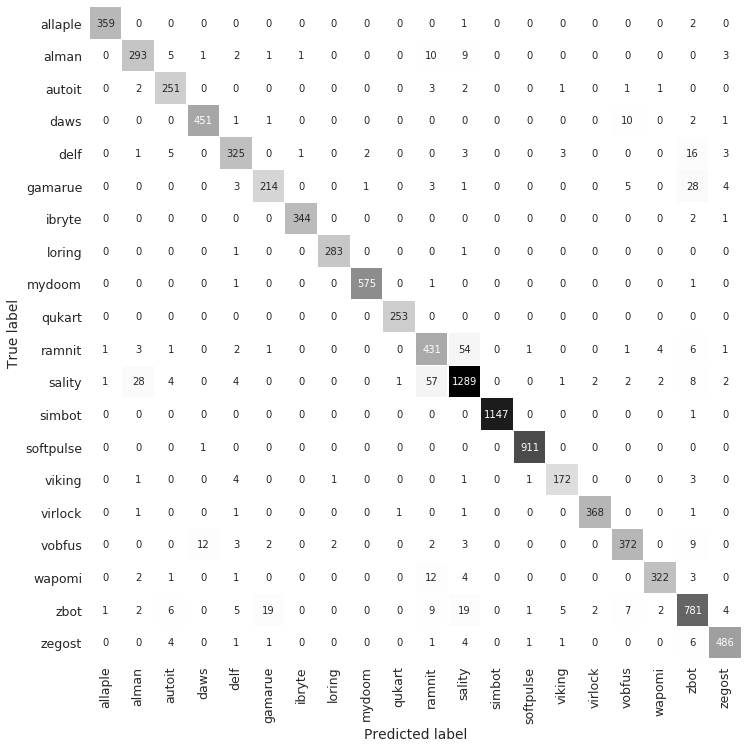

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


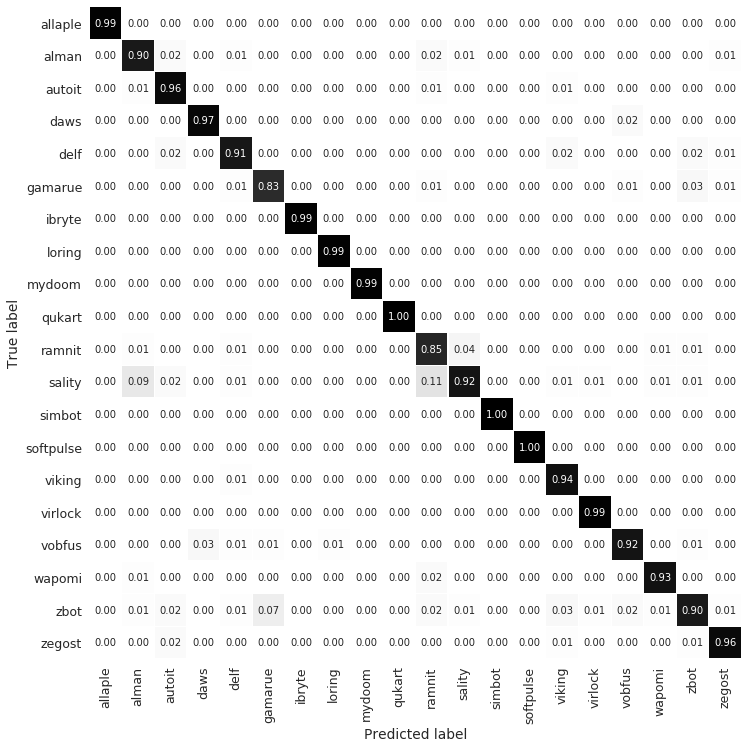

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'loss': [0.7340194414957665, 0.3935588786772618, 0.30034985560089794, 0.22382714291274078, 0.18303810863954337, 0.1466692370543284, 0.13715741248789903, 0.1193300394612815, 0.09051546527937879, 0.0767154644727478, 0.07740761936704373, 0.0815756816905126, 0.054015284941570145, 0.0785118276662176, 0.06067426324494124, 0.03479981934764162, 0.024440367961794225, 0.07146188206937985, 0.030380145675965517, 0.03869474979264284, 0.032373982551671183, 0.035640253945995, 0.04276338447539174, 0.04414860734596883, 0.014712398513500813, 0.01852716283934662, 0.035820850470082675, 0.04080418682057935, 0.017382764676148854, 0.006540885432722596, 0.006824760819595241, 0.07697295344044651, 0.01647792613665706, 0.021477512681045703, 0.013446369462664328, 0.012027936390544705, 0.018989032658397652, 0.019147245777956436, 0.014382382218509975, 0.018147492440308794, 0.0243311968730073, 0.017192584065397153, 0.018068502874860788, 0.014670638071736302, 0.00772514020294353, 0.016799329448663504, 0.038979596957

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

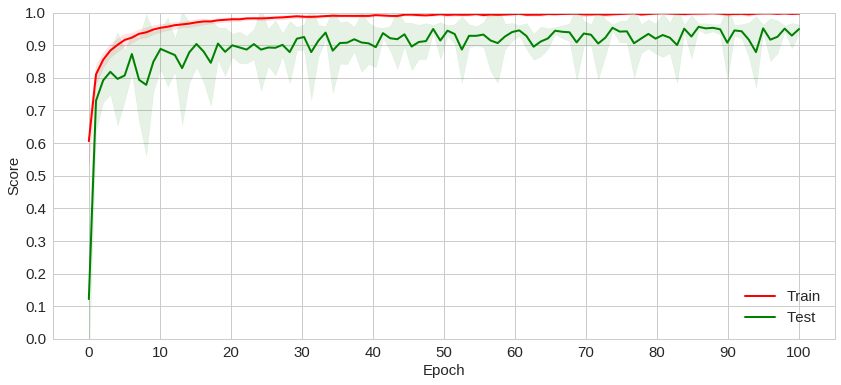

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

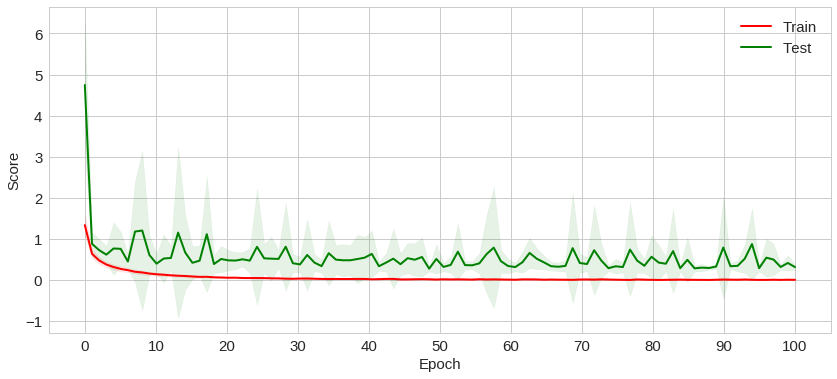

In [ ]:
plot_mean_loss(history)

In [2]:
hist = [{'loss': [0.7340194414957665, 0.3935588786772618, 0.30034985560089794, 0.22382714291274078, 0.18303810863954337, 0.1466692370543284, 0.13715741248789903, 0.1193300394612815, 0.09051546527937879, 0.0767154644727478, 0.07740761936704373, 0.0815756816905126, 0.054015284941570145, 0.0785118276662176, 0.06067426324494124, 0.03479981934764162, 0.024440367961794225, 0.07146188206937985, 0.030380145675965517, 0.03869474979264284, 0.032373982551671183, 0.035640253945995, 0.04276338447539174, 0.04414860734596883, 0.014712398513500813, 0.01852716283934662, 0.035820850470082675, 0.04080418682057935, 0.017382764676148854, 0.006540885432722596, 0.006824760819595241, 0.07697295344044651, 0.01647792613665706, 0.021477512681045703, 0.013446369462664328, 0.012027936390544705, 0.018989032658397652, 0.019147245777956436, 0.014382382218509975, 0.018147492440308794, 0.0243311968730073, 0.017192584065397153, 0.018068502874860788, 0.014670638071736302, 0.00772514020294353, 0.016799329448663504, 0.03897959695750998, 0.028314211034580154, 0.0023453587118717947, 0.0014208611699885023, 0.0007295376974427608, 0.0007342778505574837, 0.0007451068248148109, 0.0009134079110346305, 0.0007991392467270875, 0.07344016899026064, 0.02927017821172985, 0.00805032032373512, 0.0022546252467732096, 0.0034259266985556215, 0.012039376508434237, 0.026142711885399312, 0.01721991134787767, 0.008787210469530694, 0.00617216435215128, 0.009879931037619163, 0.01693926853229328, 0.009853099012206608, 0.0012187540482080368, 0.007742860698783566, 0.026265797835912486, 0.021860643574138482, 0.0032064890757858857, 0.0010340908023801765, 0.0007518076261568608, 0.000649604537016638, 0.000705205049351952, 0.0005983354293213868, 0.0007220167291959447, 0.0006262038427173159, 0.0005408606482769113, 0.0006459165017174301, 0.0006554301291533726, 0.0006748000118781179, 0.0006248674803424936, 0.0005939372316905131, 0.0006326717611785065, 0.0005641452703689183, 0.000571206323482016, 0.05533915726973064, 0.06153915305386587, 0.00799480377691297, 0.0034984868420048034, 0.0012391466121523741, 0.0026355359301007083, 0.00963056643169228, 0.01846415550870619, 0.009205014118146676, 0.01279423788265824, 0.006845498946698653], 'val_acc': [0.7177734375, 0.8486328125, 0.8330078125, 0.826171875, 0.859375, 0.7724609375, 0.8359375, 0.8701171875, 0.9013671875, 0.841796875, 0.7548828125, 0.9111328125, 0.80078125, 0.7666015625, 0.9169921875, 0.94921875, 0.9404296875, 0.830078125, 0.90234375, 0.9169921875, 0.9345703125, 0.9013671875, 0.921875, 0.9384765625, 0.955078125, 0.9296875, 0.927734375, 0.8876953125, 0.916015625, 0.927734375, 0.9501953125, 0.9453125, 0.9609375, 0.9541015625, 0.94140625, 0.935546875, 0.955078125, 0.9384765625, 0.958984375, 0.85546875, 0.9052734375, 0.947265625, 0.939453125, 0.9560546875, 0.9619140625, 0.9072265625, 0.7685546875, 0.953125, 0.9658203125, 0.9580078125, 0.9609375, 0.958984375, 0.958984375, 0.9609375, 0.95703125, 0.939453125, 0.9541015625, 0.96484375, 0.9560546875, 0.9462890625, 0.921875, 0.96484375, 0.9150390625, 0.935546875, 0.9521484375, 0.951171875, 0.9443359375, 0.958984375, 0.96484375, 0.9365234375, 0.94921875, 0.962890625, 0.958984375, 0.966796875, 0.9638671875, 0.96484375, 0.9638671875, 0.9619140625, 0.9619140625, 0.9619140625, 0.962890625, 0.9638671875, 0.962890625, 0.96484375, 0.96484375, 0.96484375, 0.9658203125, 0.96484375, 0.9658203125, 0.580078125, 0.9560546875, 0.9609375, 0.9638671875, 0.9609375, 0.9580078125, 0.9521484375, 0.939453125, 0.95703125, 0.947265625, 0.9658203125], 'val_loss': [0.9779739288287601, 0.6402489399188198, 0.5768526225002475, 0.7811690796734183, 0.48134469670185354, 1.0335576834435187, 0.6239404748957895, 0.5317793723679642, 0.4256788175102457, 0.591051085764775, 0.9437890924781982, 0.39619228699564246, 1.0346093679822843, 1.077707925112918, 0.3151574566132931, 0.30691622717722566, 0.2880958917043017, 1.1613857365057072, 0.4163526541529734, 0.33383622233026244, 0.36314971515923844, 0.5586950098690977, 0.41940163716779866, 0.30283109458447655, 0.27218274556311073, 0.33309498775635227, 0.39179860224110996, 0.5385659659473427, 0.4199774143642645, 0.4420638837252433, 0.3269917793467627, 0.28386609512999117, 0.2766297504861974, 0.2517456503290809, 0.30962880696269, 0.39084359524206747, 0.3485795122775275, 0.3658707432480468, 0.27731939390494764, 0.7664731659829158, 0.5943297807215799, 0.2957277445062245, 0.3132855672928887, 0.3088967128984583, 0.2798311101923283, 0.4275506813894747, 1.6455154490719792, 0.29386945770524164, 0.27984561968083765, 0.27434235037344257, 0.2676551979457389, 0.268195268545774, 0.2678410153971367, 0.272096743733345, 0.27316199238968597, 0.3613428456557277, 0.25509356501643143, 0.24378380834284874, 0.282609142818699, 0.3288024314200628, 0.39162438893129226, 0.26655240688648973, 0.41934817779838385, 0.3975011628371625, 0.304805051658108, 0.297176878329088, 0.32815137798255956, 0.2882725779083648, 0.28871920388973304, 0.43590603907696845, 0.34731915020017157, 0.24872091475805247, 0.26543274171103537, 0.2668443962144753, 0.27523373952730656, 0.2761322339858632, 0.2692546254940531, 0.2715619615865803, 0.27228337963717486, 0.2805762143819597, 0.2724081839608652, 0.2804230065306883, 0.27783542044795606, 0.2789657186124006, 0.27628763639884246, 0.28041577224236613, 0.2946681565514293, 0.28421960859884843, 0.2876823378748017, 4.42550503398966, 0.28706569555710315, 0.25716604275150123, 0.2592521443351026, 0.25797735959989465, 0.2811212767768603, 0.2996163022940519, 0.36393288853203654, 0.2620688344297908, 0.3480548037009399, 0.2349382376051543], 'acc': [0.7857769974184413, 0.8833406497450436, 0.9078138718697143, 0.9288849868305531, 0.943920105355575, 0.9552238805970149, 0.9561018437225637, 0.9614793678665496, 0.9706979807894726, 0.9762949957148457, 0.974868305635829, 0.9736611062858689, 0.9837576821773486, 0.9736611063381996, 0.9810140474100087, 0.9886962247585601, 0.9924275681468036, 0.9787093943101047, 0.9896839333271331, 0.9871597892888498, 0.9892449517120281, 0.9881474978574228, 0.9863915715539947, 0.9854038630377524, 0.9950614574187884, 0.9938542582258203, 0.9883669886911407, 0.9874890254609306, 0.9945127304653204, 0.9985733099209834, 0.9978050921861282, 0.9781606672519754, 0.9949517121327561, 0.9941834942932397, 0.9960491659350307, 0.996268656716418, 0.994622475856014, 0.9933055311676909, 0.9955004389815628, 0.9939640036165138, 0.9918788410886743, 0.9956101844769177, 0.9942932397885946, 0.9949517120280948, 0.9972563652326603, 0.9947322212467077, 0.9888059702015844, 0.9916593503072871, 0.999451273046532, 0.9996707638279192, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9790386303775241, 0.9901229148375769, 0.9973661106233538, 0.9996707638279192, 0.9989025460930641, 0.9964881474978051, 0.9918788410886743, 0.9948419666374012, 0.9975856015094023, 0.9982440737489026, 0.9974758560663781, 0.995171202809482, 0.9972563652326603, 0.9997805092186128, 0.9981343283582089, 0.9929762949956101, 0.994622475856014, 0.9990122914837577, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9859525900435511, 0.9814530290774445, 0.9976953467954346, 0.9989025460930641, 0.9997805092186128, 0.9991220368744512, 0.9974758561187088, 0.9938542582258203, 0.997146619946628, 0.9968173836698858, 0.9976953467954346]},
{'loss': [1.2537883253036843, 0.5894742693350664, 0.4375933155119877, 0.3524737706146717, 0.2884637527764563, 0.22692663536957017, 0.2006761600619637, 0.17122956971759098, 0.1538060014727792, 0.13051957540444592, 0.10789746221662588, 0.10078342242907452, 0.08248320768718294, 0.07303481454809153, 0.07149939208716768, 0.07972939718667552, 0.05904396624507295, 0.0684887231801736, 0.05743510835204827, 0.054929171247820215, 0.03233942811020513, 0.04352507103017487, 0.05207773032157776, 0.038490715244936594, 0.03523965194645189, 0.05073002189618942, 0.05624759657472876, 0.031241760182891116, 0.042212466638564795, 0.02847274538324079, 0.03725178661398286, 0.023731831172286003, 0.023057670558117933, 0.014417513921783408, 0.03296002702706434, 0.04377475493077237, 0.030189888580009015, 0.020374358184287695, 0.027776681719458605, 0.01911948601168278, 0.01839607145295155, 0.024664251769523776, 0.044961406414587436, 0.03222497200655763, 0.024346202212852032, 0.010273447750590192, 0.006397710279139934, 0.01918344763827721, 0.025364119164743872, 0.008915975778194208, 0.007355759807537282, 0.010567016965813384, 0.03565339939380642, 0.017357092510431583, 0.010425179429157338, 0.006270991538071178, 0.02644161137809095, 0.03029494653593481, 0.015040994197583615, 0.004383350811209487, 0.001499382722788751, 0.01143168503588187, 0.029010705414211996, 0.01916131080356932, 0.009278682346751338, 0.017319289225600547, 0.01246612343480472, 0.003937820689392381, 0.0026071253103049424, 0.0010565988346657937, 0.0011757985261165113, 0.011733682882411696, 0.052529832499053936, 0.014311990567772527, 0.012208305251756035, 0.023735243363870197, 0.011122520092337407, 0.0065279791485750565, 0.0034898850992857136, 0.01401228677719784, 0.002911715040453562, 0.012963629272890095, 0.02848920239185528, 0.010737544163352989, 0.002894803649061043, 0.0020174851886070448, 0.004270592209066028, 0.010766977161276801, 0.026002858097548827, 0.006322375808044843, 0.013408721341091449, 0.012613895926133533, 0.00731584497394698, 0.0038913261197247007, 0.004254242603757814, 0.009640093858129787, 0.022882320992441547, 0.0052786016197603, 0.012908516896809599, 0.002760772864226693], 'val_acc': [0.09784735812133072, 0.7827788659037909, 0.6389432499320074, 0.7798434442270059, 0.5058708431202839, 0.7084148751312973, 0.9363992172211351, 0.5410958920439629, 0.8718199608610567, 0.8679060674693486, 0.9021526428118144, 0.8962818031908248, 0.9266144814090019, 0.9363992172211351, 0.9227005870841487, 0.9686888454011742, 0.6467710379984981, 0.669275930249761, 0.7661448168894549, 0.9471624266144814, 0.8356164387060938, 0.9442270058708415, 0.9315068502482137, 0.9452054794520548, 0.9628180048470395, 0.8111545997589769, 0.9050880626223092, 0.8874755381604696, 0.8972602739726028, 0.9452054794520548, 0.9442270058708415, 0.87573385518591, 0.910958904109589, 0.8884540117416829, 0.5254403152111226, 0.9305283757338552, 0.9090019569471625, 0.8121330743899784, 0.9119373795570926, 0.9363992172211351, 0.8904109589041096, 0.9608610567514677, 0.8258317034771764, 0.9647749510763209, 0.9324853228962818, 0.8551859099804305, 0.9305283757338552, 0.8091976516634051, 0.9686888454011742, 0.8581213316572156, 0.9637964774951077, 0.8610567514677103, 0.9559686897785463, 0.9021526418786693, 0.9481409001956947, 0.9696673189823874, 0.6340508820259407, 0.9598825831702544, 0.9637964774951077, 0.9716242661448141, 0.9716242661448141, 0.9403131115459883, 0.8669275929549902, 0.9667318982387475, 0.8884540117416829, 0.9510763209393346, 0.9696673189823874, 0.9647749510763209, 0.9716242661448141, 0.9716242661448141, 0.9726027397260274, 0.589041095890411, 0.9549902152641878, 0.9686888454011742, 0.9598825831702544, 0.8444227005870841, 0.9686888454011742, 0.9677103718199609, 0.9637964774951077, 0.9080234833659491, 0.9657534246575342, 0.8326810176125244, 0.9099804305283757, 0.9569471624266145, 0.9315068493150684, 0.9686888454011742, 0.9696673189823874, 0.9657534246575342, 0.9549902152641878, 0.9696673189823874, 0.9129158512720157, 0.9530332681017613, 0.8561643835616438, 0.6585127221394892, 0.9647749510763209, 0.7495107651923267, 0.8610567514677103, 0.9628180039138943, 0.958904109589041, 0.9686888454011742], 'val_loss': [4.877316887831268, 0.7463158411639148, 1.4250916791104742, 0.7892509880466587, 2.482663091200125, 1.1493212409361235, 0.2323615879205205, 4.131251225976087, 0.3516401478514046, 0.46408942327862, 0.3342622328675379, 0.451215036993449, 0.25675083223708456, 0.23507140226944911, 0.3328304988954205, 0.13252066387034853, 1.4359397636753837, 2.8330154292022995, 1.0163916554908545, 0.2119658633759646, 1.1436336200586978, 0.3103074840293733, 0.2971217385945439, 0.20366687061082686, 0.2098985273734202, 0.8949699608942607, 0.5185807991628709, 0.5954490032297577, 0.45302871186088006, 0.2124556924742625, 0.2528279064857777, 0.5995608813622251, 0.36989843849582077, 0.759012960890964, 2.7952869368859243, 0.40240131525453865, 0.4023202277885734, 1.5717331779969346, 0.35761345371037423, 0.22716284922980437, 0.45359750227836576, 0.20540898463481286, 0.9936756695453098, 0.16848741818842217, 0.344753814972765, 0.8374693166325768, 0.26771666979344855, 1.3973706948127287, 0.18664194188684796, 0.9526740089494015, 0.20429969137968132, 0.9261919710568289, 0.21043843548301855, 0.582494831635528, 0.25845507354947256, 0.18079134575326214, 3.4703773540301612, 0.19443692804807738, 0.20998382522735223, 0.14811116072111166, 0.16612308397849482, 0.4057716014388803, 0.8447356251158271, 0.2482908779180953, 0.4485907855253798, 0.22250767347473063, 0.1880866343972165, 0.21599950841688345, 0.1651620097281429, 0.1718770556124094, 0.17367347121471852, 3.9185035994346697, 0.18638998947209215, 0.16421575918400744, 0.232873630588388, 0.6815980693592668, 0.15903869434738474, 0.1909721160126014, 0.1903173144446417, 0.5051316783534221, 0.18157820777392725, 0.8319231837741087, 0.46106627284940294, 0.20657243049978463, 0.340049439317701, 0.18324946261446273, 0.1616294241934378, 0.25175737154824707, 0.35148896690705583, 0.19143994314477455, 0.46878503199532645, 0.2560684219319548, 0.7562798586262687, 2.3003265646210145, 0.18038505211736763, 1.7561334808752391, 0.7090918190214122, 0.22391602692225052, 0.294493616915819, 0.23474439451222723], 'acc': [0.6284836515774453, 0.8221417602175339, 0.8660302832771714, 0.8921439544474945, 0.9132104455731483, 0.9295589204338891, 0.9373491333978647, 0.9466754445544141, 0.9495281984676832, 0.9609392143954356, 0.9646697390464044, 0.9668641651124057, 0.9745446565723064, 0.9757515909589642, 0.9760807548825982, 0.9745446565723064, 0.9821154268158876, 0.97761685319289, 0.9797015580425719, 0.9827737547547142, 0.989247311827957, 0.9860653938994953, 0.9831029186783482, 0.9878209348255431, 0.989247311827957, 0.9846390168970814, 0.9829931974620287, 0.9907834102298074, 0.9854070660522274, 0.9917709019091507, 0.9886987052885671, 0.9931972789115646, 0.9931972789115646, 0.9946236559139785, 0.9911125741534415, 0.9856265086679833, 0.9896861970594689, 0.9936361641430765, 0.9917709019091507, 0.9938556067588326, 0.9948430985297345, 0.9916611806012727, 0.9860653939910539, 0.9910028527540048, 0.9929778362958086, 0.9967083607636603, 0.9979152951503182, 0.9938556068503912, 0.9912222953697608, 0.9969278033794163, 0.9974764099188063, 0.9968180820715383, 0.9897959184589056, 0.9946236559139785, 0.9976958525345622, 0.9982444590739522, 0.9930875576952453, 0.990454246397732, 0.9949528198376124, 0.9987930656133421, 0.999670836076366, 0.9970375247788529, 0.9914417379855168, 0.9948430985297345, 0.9972569673946089, 0.9956111476848803, 0.9964889181479043, 0.9987930656133421, 0.9993416721527321, 0.999670836076366, 0.999780557384244, 0.9969278033794163, 0.9855167873601053, 0.9955014263770025, 0.9970375246872942, 0.9927583936800527, 0.9967083608552189, 0.9979152951503182, 0.999231950844854, 0.9964889181479043, 0.999012508229098, 0.9958305904837536, 0.9918806232170287, 0.9967083607636603, 0.999231950844854, 0.9993416721527321, 0.999231950844854, 0.9974764099188063, 0.9924292297564187, 0.9980250164581962, 0.9978055738424402, 0.9961597542242704, 0.9972569673030502, 0.9985736229975861, 0.9986833443054641, 0.9972569673030502, 0.9929778362958086, 0.9987930656133421, 0.9951722624533684, 0.999122229536976]},
{'loss': [1.6884173224400199, 0.8049639432563129, 0.6078828357980669, 0.5028832611571074, 0.4288725703791235, 0.3631995531381772, 0.32656950590222383, 0.30195710372250034, 0.2690626998097293, 0.24151132742254397, 0.22798865880554, 0.20936652764959154, 0.18589260301643842, 0.17200176517539195, 0.17475663081380347, 0.15862748555482714, 0.13134275558443448, 0.12881525043609007, 0.12675377988052597, 0.12006251677174404, 0.10420001771982666, 0.10607116763509022, 0.08753912931429929, 0.08432991245002235, 0.08133122919085663, 0.08400834379055688, 0.0779329899133736, 0.09211984117294303, 0.0645400667223898, 0.062429907069283655, 0.07676962106496818, 0.050864296539074864, 0.052673153250115325, 0.048931937150660444, 0.06821719313545267, 0.0443163214403827, 0.0430376221726805, 0.03405821673498914, 0.06849149157094535, 0.06441703956921967, 0.03308505871081451, 0.026439069657641274, 0.04058863353271269, 0.024506749983018973, 0.033023529653647896, 0.0398710395281823, 0.051999647567465904, 0.03033665024903049, 0.023087886173033718, 0.027838590141169104, 0.059487466127697515, 0.04063945004220818, 0.028431924616037524, 0.012678539131311837, 0.015089952599198691, 0.0417334663861698, 0.037098716647275216, 0.018043351963681616, 0.02576232917242924, 0.016993182946732664, 0.02429334931364057, 0.02948412397809107, 0.023350275720377657, 0.0223687365807377, 0.042593294285591686, 0.015627515861615034, 0.007897491354330344, 0.0070192954502546435, 0.003343719917023309, 0.07875100944089616, 0.01687493462297837, 0.009542177124539437, 0.006749227189212259, 0.034497962370626675, 0.0251008380594857, 0.018558731385154327, 0.009641404189031998, 0.021515115630386054, 0.02983905203588128, 0.019215837326965083, 0.0059834046003048235, 0.005992425515460299, 0.01519632504695732, 0.029602876720070916, 0.02309437523822, 0.015353034168991546, 0.024238363461815012, 0.016758510120872344, 0.018700625966468043, 0.008026707058628662, 0.007300102158425696, 0.005034688953337548, 0.005434607832979502, 0.026688169540149388, 0.03083614760601618, 0.007664113222550723, 0.00872949546303725, 0.027954703967981463, 0.011716932421576717, 0.016588565316110117], 'val_acc': [0.03333333333333333, 0.7725490210103053, 0.8254901967796625, 0.8088235312817144, 0.8735294136346555, 0.8784313739514819, 0.8882352955201093, 0.6500000011687185, 0.8578431386573642, 0.8833333328658459, 0.8627450989741905, 0.8960784327750112, 0.904901962186776, 0.8058823543436388, 0.9068627457992703, 0.9068627465005015, 0.9176470602259916, 0.9343137268926583, 0.904901962186776, 0.9058823543436387, 0.9245098053240308, 0.8637254915985406, 0.8823529421114454, 0.9284313739514818, 0.9225490210103053, 0.9019607852487003, 0.8588235303467395, 0.8843137268926583, 0.9362745112063838, 0.9294117661083445, 0.9411764719906975, 0.9323529425789329, 0.9078431386573642, 0.9313725499545826, 0.9186274523828544, 0.9176470602259916, 0.9421568641475603, 0.9254901974808936, 0.881372549720839, 0.939215687676972, 0.9352941190495211, 0.9245098048565434, 0.9362745112063838, 0.9323529425789329, 0.9362745107388963, 0.7029411771718194, 0.9294117661083445, 0.9441176484612858, 0.9352941190495211, 0.9352941190495211, 0.9313725504220701, 0.9313725508895575, 0.9421568641475603, 0.9284313739514818, 0.9303921582652074, 0.9098039229710897, 0.9343137268926583, 0.927450981794619, 0.9352941190495211, 0.9362745112063838, 0.9215686288534426, 0.8411764715232101, 0.927450981794619, 0.9058823543436387, 0.9235294131671681, 0.9460784323075239, 0.9421568641475603, 0.9450980406181485, 0.9460784327750112, 0.9333333347357956, 0.9372549033632466, 0.9421568641475603, 0.9480392170887367, 0.9323529425789329, 0.9411764719906975, 0.9333333347357956, 0.939215687676972, 0.9254901974808936, 0.8107843151279525, 0.9372549033632466, 0.943137256304423, 0.9323529425789329, 0.9294117661083445, 0.9362745112063838, 0.9362745112063838, 0.9372549033632466, 0.922549020542818, 0.9441176484612858, 0.9362745112063838, 0.9421568641475603, 0.9401960793663474, 0.9441176479937984, 0.9323529425789329, 0.9039215695624258, 0.9313725499545826, 0.939215687676972, 0.9333333342683081, 0.9333333347357956, 0.9323529425789329, 0.9460784323075239], 'val_loss': [5.980549971262614, 0.7789569759266634, 0.6295513715015213, 0.6879730837017882, 0.46637524467911207, 0.40919544310939576, 0.42462270899913185, 1.5303778063286753, 0.4442730224198278, 0.4079314363700356, 0.43744118172748414, 0.38323006304424456, 0.3563462264058074, 0.8213872505224072, 0.3536837144469495, 0.3322752754570297, 0.30647311060159815, 0.2481741029142594, 0.39661333432740514, 0.35908144256787705, 0.2868827019516817, 0.5562621058791182, 0.47173244549970456, 0.3455169215745734, 0.37427372303516, 0.41576226054124554, 0.4824803140214142, 0.48087999090643924, 0.32116046891447947, 0.32214524912572007, 0.30849071929232613, 0.32508973904536614, 0.4591521025586314, 0.3481122431864588, 0.372772054768903, 0.43677422534700083, 0.27905922332084654, 0.39728878346867236, 0.5922400883563301, 0.31847020785623154, 0.3488386717849862, 0.4119827162654759, 0.3473728241714668, 0.371038841188532, 0.3054152482024887, 1.469637630998577, 0.34111949974807093, 0.31081091146230555, 0.3686660883054031, 0.45918466385445506, 0.3821567985387571, 0.3844014540375575, 0.32418594526896183, 0.38503171560502164, 0.43364560900313204, 0.5365798914580802, 0.4080206112159346, 0.4634644914643929, 0.4273840704960834, 0.3634851202419401, 0.5153535809368894, 1.0393737958995404, 0.48583238887935176, 0.6619974184912137, 0.4217658504346343, 0.38279860453604114, 0.39259369247289555, 0.34940516910514685, 0.40611662952847954, 0.36637263558174316, 0.3102822172937259, 0.35710450022316925, 0.3585401418284275, 0.44268408967578743, 0.33264292453187344, 0.4042259450259329, 0.39102256739898067, 0.4706975381309121, 0.7691278482184712, 0.3597059262941296, 0.3737027688115119, 0.40265455098512093, 0.4585606446131797, 0.42781822555960203, 0.40954216465079657, 0.4622911594922408, 0.45056000899676785, 0.35133852205592975, 0.36913775090285667, 0.38322566033609035, 0.38256532767278734, 0.4263054575673782, 0.4117441509428309, 0.6351381179996376, 0.4663794772844339, 0.43939831175889726, 0.4603298007580241, 0.44964414739091024, 0.36147212096544606, 0.3603594870085513], 'acc': [0.5143703379721012, 0.769526108099003, 0.818341377692664, 0.8474111453960631, 0.8680342255375164, 0.8886573059143545, 0.8986397544351153, 0.9035761300384502, 0.9121325143652561, 0.9221149627029399, 0.9271610356465197, 0.9349495394285335, 0.9413119790427462, 0.9441641071691174, 0.9442738043524393, 0.9500877578408115, 0.9567792893188363, 0.9583150506176515, 0.9585344449319877, 0.9606186924089513, 0.9659938569548048, 0.9656647652479158, 0.9738920579201404, 0.9726853883805219, 0.9720272050713593, 0.9727950856161515, 0.9736726635534966, 0.9701623519087319, 0.9774023694602896, 0.9782799473976346, 0.9771829750936457, 0.983435717419921, 0.983106625713032, 0.984093900833699, 0.9771829749890303, 0.984752084247477, 0.9836551119434881, 0.9897981571387492, 0.9794866169372531, 0.9784993418165863, 0.9900175515577008, 0.991772707380083, 0.9859587538394032, 0.9923211935059236, 0.9891399736726635, 0.9872751207715746, 0.9818999561211057, 0.9903466432645898, 0.9916630100921456, 0.9923211935059236, 0.9824484422992541, 0.9871654234313295, 0.9912242212019348, 0.9959412022817025, 0.9958315050460729, 0.9878236070020306, 0.986836331829056, 0.9936375603334796, 0.992211496270294, 0.9944054409828872, 0.9928696796840719, 0.9910048266783678, 0.992211496270294, 0.9929793769197016, 0.9861781483106625, 0.9949539271610356, 0.9972575691092584, 0.9975866608161474, 0.999012724879333, 0.9774023695125973, 0.9949539271610356, 0.9964896884598509, 0.9982448442299254, 0.9892496709606008, 0.990895129442738, 0.9934181658622203, 0.9978060552874067, 0.99275998250075, 0.9904563405002194, 0.9945151382185169, 0.9982448442299254, 0.9982448442822331, 0.9953927161035542, 0.991224221149627, 0.9921017991392798, 0.9951733216322949, 0.9919921017990346, 0.9949539271610356, 0.9949539271610356, 0.9972575691092584, 0.9981351469942957, 0.998025449758666, 0.9982448442299254, 0.9926502852651203, 0.991224221149627, 0.9978060552874067, 0.9969284774023695, 0.9924308907415533, 0.9955024133391839, 0.9944054409828872]},
{'loss': [1.451276512627016, 0.6473284990641108, 0.4654618886217736, 0.370943433856755, 0.311062771591701, 0.27090519404594315, 0.24769388754901134, 0.19628629988353502, 0.1920314249337504, 0.162130579430806, 0.13982240334806734, 0.1298869873772849, 0.12367283133626507, 0.1190754090337769, 0.09334480201073905, 0.08231004692385332, 0.0835264179888263, 0.07115337766192266, 0.06915974611632951, 0.06012992568134347, 0.0724379649927039, 0.049858814662040556, 0.05853784097044059, 0.05082176637114843, 0.04320129455534921, 0.04944176708711638, 0.04768861443020828, 0.030856454291604583, 0.02669706185753743, 0.06280796473974509, 0.04966205953780701, 0.04117470632395054, 0.02401764097211478, 0.024019466100052293, 0.021567603350660904, 0.014121389944525537, 0.0422109344742989, 0.04069568412163981, 0.02705280125815638, 0.03376094384085471, 0.019838533457406906, 0.01817609610506336, 0.011948737841515124, 0.049686191220589856, 0.02158865083329785, 0.018553457462640883, 0.022442174531623317, 0.017321937710623483, 0.029162482186598424, 0.029405440132349643, 0.0211779524835979, 0.01603326818240659, 0.01985225562350439, 0.040537718873677304, 0.03520842319527506, 0.017542112364383668, 0.007688545421523598, 0.012608241841564704, 0.018074940945211494, 0.014864970351395881, 0.010196329926092356, 0.030617161555008415, 0.021853336183790307, 0.015995742396463404, 0.006704392620891317, 0.015817750501471956, 0.025349727145788946, 0.01827182007896466, 0.00596740951806376, 0.008859862623232498, 0.022732395968062504, 0.020581778856100293, 0.006058577535471462, 0.005583942147080833, 0.029804531347008778, 0.02541851511208127, 0.009415313916638536, 0.024920721141193338, 0.011303861036267654, 0.005585371636614087, 0.00408829512417198, 0.003483291209114102, 0.009028243820508227, 0.027157769996981523, 0.01829636704521698, 0.00827869658424836, 0.016289251098051315, 0.015964018802329966, 0.009785607351979085, 0.011936260719402637, 0.006278680808513296, 0.0035234713644006644, 0.008466410770083792, 0.022035478444018864, 0.014730451925179135, 0.005536672883480158, 0.015913948909207665, 0.013780459501687577, 0.010812331734781, 0.014673428928102096], 'val_acc': [0.05708661417322835, 0.764763779527559, 0.8326771653543307, 0.8789370088126716, 0.8759842519685039, 0.7263779527559056, 0.8651574803149606, 0.7824803158992858, 0.8031496062992126, 0.9350393700787402, 0.9232283464566929, 0.9114173228346457, 0.8622047248787768, 0.9251968503937008, 0.8946850393700787, 0.9271653543307087, 0.8937007874015748, 0.9311023622047244, 0.9291338582677166, 0.765748031496063, 0.8986220472440944, 0.9350393700787402, 0.8769685039370079, 0.9330708661417323, 0.9242125984251969, 0.9330708661417323, 0.9301181102362205, 0.9330708666110602, 0.9133858272409815, 0.8917322834645669, 0.8346456695260025, 0.937992125984252, 0.9330708661417323, 0.9399606299212598, 0.937007874015748, 0.9370078744850759, 0.8818897637795275, 0.9163385826771654, 0.9409448818897638, 0.9291338582677166, 0.9212598425196851, 0.9163385831464933, 0.9350393705480681, 0.9399606299212598, 0.9291338582677166, 0.9311023622047244, 0.9143700787401575, 0.8877952755905512, 0.9320866141732284, 0.937992125984252, 0.9133858267716536, 0.9360236220472441, 0.7874015752724776, 0.9212598425196851, 0.9291338582677166, 0.937007874015748, 0.9458661417322834, 0.9419291338582677, 0.9399606299212598, 0.9399606299212598, 0.9320866146425563, 0.9124015748031497, 0.8710629930646401, 0.9429133858267716, 0.9419291338582677, 0.937007874015748, 0.9389763779527559, 0.9399606299212598, 0.9409448818897638, 0.9419291338582677, 0.9360236220472441, 0.952755905511811, 0.9468503937007874, 0.952755905511811, 0.8484251968503937, 0.9409448818897638, 0.9340551181102362, 0.9399606299212598, 0.9448818897637795, 0.9202755905511811, 0.9350393700787402, 0.9478346456692913, 0.8966535433070866, 0.9232283464566929, 0.9350393700787402, 0.9429133858267716, 0.937007874015748, 0.9301181102362205, 0.9409448818897638, 0.9478346456692913, 0.9468503937007874, 0.9488188976377953, 0.9468503937007874, 0.6830708661417323, 0.9507874015748031, 0.9507874015748031, 0.7992125984251969, 0.9409448823590917, 0.9340551181102362, 0.9320866146425563], 'val_loss': [6.523591670464343, 0.686213017961993, 0.6260445540858888, 0.4421565875169953, 0.5323818747005077, 0.8078781271896024, 0.5648942077844074, 0.6758633031267819, 0.8061732031683636, 0.27514179046339116, 0.3055550278221222, 0.31301353072498256, 0.5511652938654925, 0.2785475637651907, 0.40445725626759527, 0.3100614325164824, 0.45627389727430606, 0.3132661026204549, 0.34568759130205595, 0.9920732640133305, 0.47077177792373204, 0.34526283469691893, 0.5251269368674825, 0.30490767836132376, 0.3746543863592197, 0.3652118546367636, 0.314784211329976, 0.36103520874548295, 0.4145733573841587, 0.48628104095118174, 0.7829434216499954, 0.3039627279721013, 0.3724640282931203, 0.3431235901720415, 0.3558899175640986, 0.37885160445775695, 0.5377484025407069, 0.4473221665608134, 0.38760065635782787, 0.4006803587870995, 0.44255469212497356, 0.47283948057975783, 0.383663966459247, 0.34665874992492, 0.42642967986081187, 0.36651008966244863, 0.5540518016855641, 0.5645724225685798, 0.3167468857048613, 0.3391155329229654, 0.5924878399030239, 0.3300165505446763, 1.1811966477942792, 0.40784295260525094, 0.38627968417045766, 0.3197851438863092, 0.33785948575616864, 0.35363406483590926, 0.3525720793828825, 0.41893341731533623, 0.4132467774325471, 0.4620911841264295, 0.5852166006258417, 0.32737953427507466, 0.42177749914566176, 0.36297275926397793, 0.3451614864910885, 0.39078444252835004, 0.3526197743447592, 0.39338436971159113, 0.40504738693717235, 0.31409667311843026, 0.3897279808119807, 0.36551139126190335, 0.8611625078952125, 0.3246036275555779, 0.3906960765652813, 0.32950923241582325, 0.3189066330682763, 0.4416246619975435, 0.3580452441920825, 0.3371272367536203, 0.6605102196755167, 0.42248915686371635, 0.4294703087075191, 0.3932348158005919, 0.44613318502106636, 0.37706072400636265, 0.39554780428211445, 0.33906662344276084, 0.3269643782965542, 0.3129864479340327, 0.3309344190606716, 2.738664396484401, 0.30403870221237733, 0.31379341637495856, 1.6075905354507452, 0.39429573927611145, 0.42518594626997896, 0.45012775075089684], 'acc': [0.5664473684210526, 0.8078947368421052, 0.8596491228070176, 0.8911184210526316, 0.906688596491228, 0.9197368421052632, 0.9269736842105263, 0.9406798245614035, 0.9403508771929825, 0.9510964912280702, 0.9565789473684211, 0.9598684210526316, 0.9604166666666667, 0.9607456140350877, 0.969078947368421, 0.9734649122807018, 0.9725877192982456, 0.9766447368421053, 0.9792763157894737, 0.980701754385965, 0.9755482456140351, 0.9833333333333333, 0.9803728070175438, 0.9836622807017544, 0.9866228070175439, 0.9845394736842106, 0.9849780701754386, 0.9906798245614035, 0.9911184210526316, 0.9805921052631579, 0.9850877192982456, 0.9864035087719298, 0.9922149122807018, 0.9923245614035088, 0.993530701754386, 0.9960526315789474, 0.9870614035087719, 0.9869517543859649, 0.9919956140350877, 0.9895833333333334, 0.994188596491228, 0.9942982456140351, 0.9956140350877193, 0.9846491228070176, 0.9933114035087719, 0.9947368421052631, 0.9929824561403509, 0.9950657894736842, 0.9910087719298246, 0.9923245614035088, 0.9933114035087719, 0.9947368421052631, 0.9948464912280702, 0.9862938596491229, 0.9895833333333334, 0.9944078947368421, 0.9972587719298246, 0.9958333333333333, 0.9932017543859649, 0.9955043859649123, 0.9968201754385965, 0.9908991228070175, 0.9932017543859649, 0.9945175438596491, 0.9975877192982456, 0.9949561403508772, 0.9925438596491228, 0.9948464912280702, 0.9980263157894737, 0.9973684210526316, 0.9926535087719298, 0.9933114035087719, 0.9973684210526316, 0.9981359649122807, 0.9902412280701754, 0.9928728070175439, 0.9970394736842105, 0.9925438596491228, 0.9969298245614036, 0.9982456140350877, 0.9987938596491228, 0.9990131578947369, 0.9970394736842105, 0.9917763157894737, 0.993859649122807, 0.9969298245614036, 0.9951754385964913, 0.9953947368421052, 0.9963815789473685, 0.9955043859649123, 0.9985745614035088, 0.9989035087719298, 0.9986842105263158, 0.9944078947368421, 0.9952850877192982, 0.9984649122807018, 0.9959429824561403, 0.9957236842105263, 0.9966008771929824, 0.9953947368421052]},
{'loss': [1.3330714193352482, 0.6712886769520608, 0.4808732247143461, 0.40782931004569195, 0.34411957172448177, 0.2854369322066767, 0.23971960223034808, 0.20512389780528711, 0.17625700268044805, 0.15811934002364675, 0.1473448119681786, 0.14552327875995583, 0.11452851296451531, 0.10640337132897816, 0.09567631514775649, 0.07226854218210894, 0.07936271755004368, 0.07933672385110536, 0.05797747597139198, 0.052302278262326134, 0.061049675511139066, 0.05338132577650086, 0.034236345130831757, 0.05305828961641773, 0.07080065343823087, 0.043988256729509186, 0.04232187556151889, 0.03721620049199963, 0.03246656500524024, 0.0422873986540301, 0.02721800502627606, 0.02379328271161189, 0.042708397870005126, 0.039297963278888924, 0.03140260922102658, 0.03242979460891659, 0.03149314114503285, 0.029488963486367363, 0.03280518128074044, 0.02103064195809502, 0.02206798651202821, 0.03716033090218971, 0.014703829430420643, 0.02559418667416985, 0.018546004196711388, 0.03770517662901272, 0.036411684608946525, 0.019621765494830152, 0.014288840379461027, 0.01817209454720956, 0.009448965610707155, 0.028864464686372677, 0.008947197159607624, 0.013211275361561747, 0.022678093041569106, 0.012935345281789124, 0.01668050031263639, 0.022203415954253725, 0.012596393360701385, 0.012329218123966456, 0.006950345995241142, 0.04274731949664241, 0.005901142984007572, 0.006536735714624292, 0.01963863086332008, 0.018958303276734735, 0.01511291252509341, 0.012016150496658572, 0.013209307003078145, 0.005024678714805001, 0.0025394075378595486, 0.023330182991016874, 0.009908482611191222, 0.01564975611117756, 0.014096975197361118, 0.001844399998079002, 0.004166902075660386, 0.031176178471839608, 0.018068526675696167, 0.0030897560401578965, 0.0022326808510813446, 0.012464281466446393, 0.02211888508474594, 0.005655328585543142, 0.014014421968530562, 0.005475588894594758, 0.0015752118985027776, 0.0010306617242074362, 0.0010516040931440585, 0.047210493369050054, 0.010811485414983748, 0.010342737937147224, 0.012159250281290536, 0.006669319136851795, 0.0018169886104182726, 0.009102774225891808, 0.009427849162943659, 0.007424736664163726, 0.013643638022441545, 0.006730514545278821], 'val_acc': [0.05708661417322835, 0.6624015752724776, 0.7677165359023987, 0.8120078744850759, 0.8602362209417689, 0.8996062996819263, 0.8976377957449184, 0.8976377957449184, 0.9183070875528291, 0.7854330708661418, 0.9173228355843251, 0.936023622516572, 0.9340551185795641, 0.9222440949575169, 0.9379921269229078, 0.9340551185795641, 0.9399606303905877, 0.9527559059811389, 0.9448818897637795, 0.9242125993638527, 0.9370078749544039, 0.9429133867654275, 0.9320866146425563, 0.9291338587370445, 0.9281496067685405, 0.810039371017396, 0.9468503946394432, 0.9173228351149972, 0.9419291343275956, 0.9478346461386192, 0.9537401579496428, 0.950787402044131, 0.9399606303905877, 0.9409448823590917, 0.9498031500756271, 0.9547244099181468, 0.9498031500756271, 0.9389763784220838, 0.9517716544819629, 0.9242125988945248, 0.9448818902331074, 0.9498031500756271, 0.9557086618866507, 0.9557086618866507, 0.9547244099181468, 0.9438976382646035, 0.8986220481827503, 0.9566929138551546, 0.9438976382646035, 0.9488188985764511, 0.9458661422016114, 0.9557086618866507, 0.9478346461386192, 0.9586614182614904, 0.936023622516572, 0.9557086618866507, 0.9370078744850759, 0.9429133867654275, 0.9566929138551546, 0.9566929138551546, 0.9468503941701153, 0.950787402513459, 0.9586614182614904, 0.8858267725921991, 0.9291338592063724, 0.9330708666110602, 0.9557086623559786, 0.950787402513459, 0.9606299217291704, 0.9635826776346822, 0.9557086618866507, 0.9488188981071232, 0.9616141741670022, 0.9557086618866507, 0.9616141741670022, 0.9576771662929865, 0.9606299217291704, 0.9251968508630287, 0.9537401579496428, 0.9576771658236586, 0.9596456697606665, 0.9281496067685405, 0.9586614177921625, 0.9625984256661783, 0.9478346466079471, 0.9645669296031861, 0.9566929138551546, 0.9616141736976743, 0.9635826776346822, 0.9576771658236586, 0.9576771658236586, 0.9301181107055484, 0.9596456697606665, 0.9606299217291704, 0.9468503941701153, 0.9606299217291704, 0.9576771658236586, 0.9596456702299944, 0.9370078744850759, 0.9537401579496428], 'val_loss': [3.999561951855036, 0.9964578129409805, 0.7196678808472288, 0.5627046582384372, 0.43685842668784297, 0.32704538573312947, 0.32414477864485675, 0.38152036622283964, 0.31584201389043703, 0.8539933340531085, 0.26938615931691506, 0.27817559308849327, 0.25132912802181756, 0.31204817935024154, 0.2435726611156282, 0.3169631019264155, 0.22595283206676933, 0.2183064841832331, 0.26061357198119284, 0.3212228511420251, 0.29454004410479495, 0.2180636140848345, 0.3593302863186196, 0.30844439395259254, 0.35713027359285954, 0.7082344109603153, 0.22763394375386262, 0.46373014367911064, 0.24051358386434835, 0.2693293261381679, 0.22164592903657124, 0.2186686305726796, 0.30166933061802526, 0.24438441462630306, 0.2905900761347905, 0.27330722879918223, 0.2522234331520855, 0.3597627128218789, 0.2515120809135981, 0.36416466120017577, 0.3415487316522354, 0.25638361795067904, 0.27879259943070583, 0.2512356954251648, 0.23102516736368106, 0.3141089861807033, 0.48267149444457996, 0.2678690277963333, 0.3381061353243003, 0.25629676664006473, 0.3164427911883591, 0.26532038135376135, 0.32205257473394094, 0.2942509980433795, 0.3636024366273672, 0.3318076218182443, 0.3750356384131291, 0.32428445104880316, 0.25218466955757557, 0.28154926989736895, 0.29301233460571674, 0.30871190506405227, 0.2789657517303368, 0.6724716722422337, 0.47310561094122555, 0.510459098870557, 0.2546255695544324, 0.3022208932448659, 0.29875199393764634, 0.26430003818460335, 0.2935198603243185, 0.31800092733106483, 0.24050274578137903, 0.3007093859400444, 0.24052675609152316, 0.25517425144856387, 0.28614628571735345, 0.3729800193302829, 0.269924379955576, 0.2591668619385783, 0.241340534241147, 0.47095187878069755, 0.27169327763084716, 0.2670111789888414, 0.2886050120089965, 0.26418941060802315, 0.25746670663227894, 0.27655502732498355, 0.27584834769905275, 0.2724100971903069, 0.3033891937827596, 0.3625056073735307, 0.23831711915580117, 0.2732446912117148, 0.3157933625498444, 0.2951985454948728, 0.3360367094317, 0.26208200316581026, 0.3842258148436425, 0.30961524046242084], 'acc': [0.6018640350877194, 0.8019736842105263, 0.8588815789473684, 0.8744517543859649, 0.8934210526315789, 0.912061403508772, 0.925548245614035, 0.937061403508772, 0.9453947368421053, 0.9487938596491228, 0.9531798245614035, 0.9539473684210527, 0.9612938596491228, 0.962938596491228, 0.9677631578947369, 0.975219298245614, 0.974561403508772, 0.9740131578947369, 0.980701754385965, 0.9823464912280702, 0.9783991228070176, 0.9827850877192983, 0.9884868421052632, 0.9825657894736842, 0.9786184210526315, 0.9857456140350878, 0.9855263157894737, 0.9888157894736842, 0.9902412280701754, 0.9867324561403509, 0.9918859649122806, 0.9930921052631579, 0.9861842105263158, 0.9867324561403509, 0.9901315789473685, 0.9899122807017544, 0.9908991228070175, 0.9895833333333334, 0.9894736842105263, 0.993859649122807, 0.9930921052631579, 0.9866228070175439, 0.9961622807017544, 0.9908991228070175, 0.994188596491228, 0.988048245614035, 0.9893640350877193, 0.9933114035087719, 0.9953947368421052, 0.9947368421052631, 0.9970394736842105, 0.9913377192982457, 0.9972587719298246, 0.9956140350877193, 0.9930921052631579, 0.9953947368421052, 0.994188596491228, 0.9928728070175439, 0.9959429824561403, 0.9962719298245614, 0.9976973684210526, 0.9866228070175439, 0.9981359649122807, 0.9975877192982456, 0.9946271929824562, 0.9945175438596491, 0.9951754385964913, 0.9958333333333333, 0.9951754385964913, 0.9987938596491228, 0.9992324561403508, 0.993421052631579, 0.9974780701754385, 0.9951754385964913, 0.9956140350877193, 0.999561403508772, 0.9987938596491228, 0.9910087719298246, 0.9947368421052631, 0.9992324561403508, 0.9994517543859649, 0.9958333333333333, 0.9925438596491228, 0.9982456140350877, 0.9962719298245614, 0.9984649122807018, 0.9997807017543859, 0.9997807017543859, 0.999671052631579, 0.987390350877193, 0.9962719298245614, 0.9966008771929824, 0.9966008771929824, 0.9983552631578947, 0.9994517543859649, 0.9970394736842105, 0.9974780701754385, 0.9975877192982456, 0.9957236842105263, 0.9978070175438597]},
{'loss': [1.4071357637170243, 0.6595214974259677, 0.5315352946503522, 0.39127328629036473, 0.34609958762991916, 0.2897496055054338, 0.27718425609477576, 0.21162894040591096, 0.23105691075325013, 0.17437581663099053, 0.15096123977883222, 0.13365501981565397, 0.14098261847724652, 0.10601401244287621, 0.1013096425696595, 0.12497993006955271, 0.08638246440652707, 0.06841667115402549, 0.07381541053073047, 0.06114855562681205, 0.06379601356285075, 0.07544509102421978, 0.04889651267495874, 0.04815957629547952, 0.04678084456134741, 0.09693350512279222, 0.054902463886019305, 0.07823538442721514, 0.024724867495288752, 0.024034203755273802, 0.04397617436220793, 0.022061160957032484, 0.04211320875266133, 0.05271042712251592, 0.03340745967644114, 0.03276811480096044, 0.02652987455750165, 0.045834186978331984, 0.023209344973328383, 0.02022457485581901, 0.027054686931765652, 0.05448423816702545, 0.04409036916362166, 0.010747711827506452, 0.013477681357281168, 0.03767152164942802, 0.031012538290955766, 0.017520435402692894, 0.036186873417156304, 0.009336926117070555, 0.009147822094112412, 0.012830068176296502, 0.04258409231390855, 0.024239280528988535, 0.018925628269454847, 0.016999384438028967, 0.015769818912086408, 0.015777536919021545, 0.015851132786896538, 0.03363892375062896, 0.016834084342501752, 0.0032221282354465523, 0.002270829671838764, 0.0410292466033939, 0.007952518970030999, 0.0282047673245439, 0.00541406950778615, 0.0013219061302569733, 0.013804299873818184, 0.037073101999876026, 0.036073629307267194, 0.009811779091273209, 0.01809924350001479, 0.026032396894308727, 0.004964649125314892, 0.002062850716103216, 0.007183360264788275, 0.01747685922679734, 0.020512642522623175, 0.015176125999431649, 0.006241684352005481, 0.01788970392259246, 0.013795731170916266, 0.0228056413708765, 0.005926123306854494, 0.0016710899364881374, 0.0013691223073674088, 0.004598160023672453, 0.02782651010976007, 0.014787377068342334, 0.008876254011065163, 0.030987631143241393, 0.01910814432658204, 0.01580817133297646, 0.0017128299888237762, 0.0026657260590103736, 0.007607354098562572, 0.003274109646294239, 0.0120827196172665, 0.006808601184026299], 'val_acc': [0.036597428288822946, 0.5667655788708393, 0.7873392682577807, 0.8971315533305959, 0.8931750745966691, 0.727992087455225, 0.8625123644087365, 0.91691394700023, 0.6280909992172268, 0.9000989123810411, 0.9426310587707543, 0.5647873396807443, 0.7962413452027696, 0.926805143835047, 0.8981206734267706, 0.9337289816194189, 0.7636003960605663, 0.5331355096029834, 0.9297725028854921, 0.7260138479113932, 0.8367952526382122, 0.78733926887682, 0.8160237392850964, 0.8130563802346513, 0.5192878341816299, 0.8862512372249901, 0.6577645898690682, 0.9386745796241345, 0.8298714144411474, 0.950544015825915, 0.9475766567754699, 0.8625123644087365, 0.7794263108194052, 0.9574678540229797, 0.7685459944779748, 0.9475766571881628, 0.9139465879497849, 0.9238377851972948, 0.9535113752890529, 0.7309594463288017, 0.9357072209863823, 0.943620178454236, 0.9653808110781404, 0.9475766567754699, 0.950544015825915, 0.9050445103857567, 0.8793273986152325, 0.9564787339268052, 0.9554896142433235, 0.9455984174085065, 0.9554896146560163, 0.9624134520276953, 0.7220573683520807, 0.8447082105187587, 0.8941641946928437, 0.9218595454176385, 0.9584569732937686, 0.9554896142433235, 0.9485657764589516, 0.923837784371909, 0.9614243323442137, 0.9594460929772503, 0.8338278935877671, 0.8456973297895475, 0.9554896146560163, 0.9535113748763601, 0.9386745800368275, 0.9634025721238699, 0.5667655784581465, 0.8288822941681044, 0.9426310587707543, 0.9535113752890529, 0.7715133539411128, 0.946587537504681, 0.9584569732937686, 0.9624134520276953, 0.9406528194037909, 0.8981206726013847, 0.9564787339268052, 0.8051434227667977, 0.9614243323442137, 0.8288822951703586, 0.5568743820360224, 0.9574678540229797, 0.9634025721238699, 0.966369931174315, 0.9594460933899431, 0.9535113752890529, 0.9119683485828215, 0.9406528194037909, 0.9584569732937686, 0.9485657764589516, 0.8160237388724035, 0.9574678540229797, 0.9693372898120672, 0.8358061333674234, 0.9554896142433235, 0.9515331355093967, 0.8278931754868769, 0.9584569732937686], 'val_loss': [6.269844336750245, 1.4063045351547727, 0.7842735446820055, 0.35321879879686413, 0.3810743329310504, 0.9099823421588522, 0.49880240467016823, 0.2990157041034517, 1.3872750175179067, 0.3214372784916314, 0.2045473355010706, 2.266307699412078, 1.0588357835293243, 0.26562123781894253, 0.4011347618849425, 0.2195616305104804, 0.866509534307119, 4.678164800228302, 0.2620658157780776, 1.1490978639609188, 0.6337392980253101, 0.9855169742529369, 0.7380503098435922, 0.675400690684783, 5.041459806712988, 0.48561242180273057, 2.0993622005517207, 0.28646659621343684, 1.0242623113530593, 0.24823955632608266, 0.3048625691370104, 0.4557466730756402, 0.9508979515670918, 0.18994231892706873, 1.3837327277130087, 0.2784377175457925, 0.36766956217876035, 0.28772254499152333, 0.22983808866837888, 1.9878514967177126, 0.3182390345438513, 0.2634511961798362, 0.18873834434591008, 0.28530681318811635, 0.28385585244585326, 0.4131105838985606, 0.49951352594150217, 0.2154339787742621, 0.19794362624347034, 0.29348391811343094, 0.2928530857275354, 0.23768473275859203, 1.6082823162329791, 0.5161211664347065, 0.5064972654856151, 0.4413046910253082, 0.2404173906597484, 0.27525159068259436, 0.2897887597730975, 0.3633629089318314, 0.23808579801219, 0.255979064519928, 1.5870300313273766, 0.7535558964124167, 0.23788389572552385, 0.25541074287936727, 0.26715778455299927, 0.2233868306540465, 4.782408355295621, 1.066521809365514, 0.29706623494429346, 0.2927448940365861, 1.607590559085153, 0.2863299840089653, 0.24057327687591112, 0.23330000949825677, 0.29679096683950046, 0.5981970789603889, 0.2503375759946843, 2.055935303175239, 0.2500607796306113, 0.611359959903915, 3.7304203388901085, 0.23349097663177326, 0.2299829104788596, 0.24221541754263337, 0.2688508583161517, 0.3144212118455744, 0.41491261154771353, 0.2851856528212197, 0.23589898942999096, 0.30692520961919056, 1.2055670515921775, 0.23509091092261583, 0.19808112372857428, 1.0609379798476732, 0.32756962915235843, 0.34585867581437535, 0.8714224944944433, 0.3131716867155603], 'acc': [0.5766575342531074, 0.8052602739791348, 0.8451506849445709, 0.8762739726158038, 0.8923835616503676, 0.911123287684297, 0.9118904109589041, 0.933041095896943, 0.9256986301435183, 0.9436712328767123, 0.9526575342465753, 0.9561643835616438, 0.9566027397325594, 0.9630684931506849, 0.968000000006532, 0.9610958904109589, 0.9716164383561644, 0.9780821917808219, 0.974027397260274, 0.9799452054794521, 0.9808219178082191, 0.9753424657534246, 0.9825753424657534, 0.9841095890410959, 0.9841095890476279, 0.9697534246640662, 0.9827945205610092, 0.9741369863013699, 0.992, 0.9924383561709156, 0.9853150684931506, 0.9926575342465753, 0.9863013698695458, 0.982027397260274, 0.9886027397260274, 0.9902465753424657, 0.9917808219243403, 0.9860821917808219, 0.992, 0.9934246575342466, 0.9911232876777649, 0.983013698636669, 0.9872876712328768, 0.9966027397260274, 0.9952876712328768, 0.9891506849380388, 0.991013698630137, 0.9933150684996827, 0.9894794520547945, 0.9969315068493151, 0.9978082191780822, 0.9960547945205479, 0.9863013698630136, 0.991013698630137, 0.9941917808219178, 0.9941917808219178, 0.9957260273972602, 0.9948493150684932, 0.9940821917873539, 0.9901369863013698, 0.9949589041095891, 0.9992328767123287, 0.9992328767188607, 0.9866301369863014, 0.9975890410958904, 0.9934246575342466, 0.9987945205479452, 0.9996712328767123, 0.9950684931506849, 0.9873972602870367, 0.9905753424657534, 0.9972602739726028, 0.9948493150750252, 0.9927671232876712, 0.998027397260274, 0.9994520547945206, 0.9979178082257101, 0.9945205479452055, 0.9945205479452055, 0.9958356164383562, 0.9976986301369863, 0.9938630136986302, 0.9958356164448882, 0.9925479452054794, 0.9984657534246575, 0.9995616438356164, 0.9996712328767123, 0.9985753424657534, 0.992, 0.9947397260273972, 0.9974794520613265, 0.9899178082191781, 0.9940821917873539, 0.9955068493150685, 0.9994520547945206, 0.9994520547945206, 0.9972602739726028, 0.9992328767123287, 0.9961643835616438, 0.998027397260274]},
{'loss': [1.5392175638441894, 0.727265936071593, 0.5521209123780618, 0.44222624602056065, 0.37440936650557993, 0.3749214914420537, 0.27891668007618575, 0.2455148506010429, 0.23903317394399742, 0.2000260316798737, 0.17275613510779775, 0.1687912136092627, 0.13412993025841602, 0.13701548027916494, 0.150917202567328, 0.12700393411478939, 0.1122844776870701, 0.11009585981472463, 0.08013942842123294, 0.07617383621044484, 0.06493033313570895, 0.06832155112923662, 0.0673740429429649, 0.056347443237394615, 0.06877864644517509, 0.06393708649474177, 0.04273378244093335, 0.0464364420460343, 0.06196431256708244, 0.02924798295576641, 0.05263670110407496, 0.05065723108817506, 0.0322205276227263, 0.02499605890687331, 0.03710328032190889, 0.038338142800692504, 0.032657062127685, 0.02009521509120762, 0.03562782275229954, 0.053177033520017035, 0.01939883397375436, 0.02534607292592997, 0.031342401304903164, 0.07797957833913895, 0.015642520010981698, 0.006007583351721674, 0.015621083914306626, 0.025849685308108324, 0.039088059284747664, 0.023591401348209067, 0.026174087170210466, 0.042950023366841394, 0.012848402560845238, 0.020922858373545048, 0.015169757563271687, 0.026117489980734227, 0.013856306300701147, 0.039963204783102384, 0.03113108569996787, 0.013184171456476232, 0.010236331075617416, 0.010269652277928254, 0.04305316232475648, 0.03622858859449339, 0.00653731101954648, 0.011900711329872736, 0.01577006057528985, 0.01016546307889046, 0.019147208882848564, 0.01435719348449843, 0.028851904573349213, 0.006105748865188568, 0.012066486643143576, 0.03124317518400266, 0.01870129281108515, 0.011201143839913951, 0.007279906968445624, 0.027481334904072265, 0.009145309183623183, 0.011673101114375585, 0.012619998014069761, 0.011264255132561147, 0.011686633835915823, 0.03574968092948252, 0.010303624212783276, 0.005937341010002131, 0.027360077871064706, 0.006801948505426007, 0.006415053354983164, 0.0030081372591146908, 0.018666451371890314, 0.01065859483712854, 0.0276439880803394, 0.002979254390547518, 0.007582752922235971, 0.00456342935001728, 0.024112090139343383, 0.007194320515247388, 0.01420391088679884, 0.02057200115854996], 'val_acc': [0.09613478691774034, 0.7661050546866343, 0.819623389494549, 0.8434093161546086, 0.8374628344895937, 0.8721506452654941, 0.908820614469772, 0.9276511398604651, 0.9127849366430958, 0.9286422210831354, 0.9335976224706478, 0.9405351844131651, 0.8265609515552124, 0.9117938563655933, 0.93359762152548, 0.9197224975222993, 0.9444995044598612, 0.9494549058473737, 0.9454905858006775, 0.9405351844131651, 0.933597621407334, 0.9415262636273538, 0.9454905847373637, 0.8444003966388665, 0.9355797819623389, 0.9524281466798811, 0.9454905847373637, 0.8969276512578883, 0.9474727452923687, 0.9494549059655196, 0.9484638256289442, 0.9355797819623389, 0.9355797830256527, 0.9554013875123885, 0.9425173439048563, 0.9415262646906676, 0.9345887027481502, 0.9474727463556825, 0.9554013875123885, 0.9286422210831354, 0.9514370674656923, 0.9494549058473737, 0.9276511397423192, 0.9395441030723488, 0.9554013875123885, 0.9563924688532047, 0.9563924688532047, 0.9266600594648167, 0.9554013875123885, 0.9127849366430958, 0.9514370664023786, 0.8959365708622399, 0.9554013875123885, 0.9603567888999008, 0.9494549069106875, 0.94648166607818, 0.9494549069106875, 0.9444995044598612, 0.9514370674656923, 0.9573835491307072, 0.9583746294082097, 0.9573835491307072, 0.8622398414271556, 0.9534192269573836, 0.9514370674656923, 0.9504459861248761, 0.9554013885757023, 0.9554013885757023, 0.9415262646906676, 0.9514370674656923, 0.9494549058473737, 0.9534192280206973, 0.8721506452654941, 0.9454905858006775, 0.9504459871881898, 0.9534192280206973, 0.9504459871881898, 0.9504459871881898, 0.9593657096857122, 0.9633300297324083, 0.9534192280206973, 0.9425173439048563, 0.923686819695623, 0.9464816650148662, 0.956392467789891, 0.9573835491307072, 0.9266600605281304, 0.9544103082981998, 0.9633300307957221, 0.9593657096857122, 0.9345887027481502, 0.956392467789891, 0.94648166607818, 0.9494549058473737, 0.9375619425173439, 0.9415262636273538, 0.9415262636273538, 0.9464816650148662, 0.9524281466798811, 0.9454905847373637], 'val_loss': [4.187950207291557, 0.7577587962150574, 0.6361888719148513, 0.5212104887146839, 0.5935404490757036, 0.48148420664626734, 0.33410300179573865, 0.23956507772236796, 0.3042347826418071, 0.26018958258872016, 0.22233180278134532, 0.21081531222640168, 0.6397189329645059, 0.31967815565237473, 0.24404942095847348, 0.27224457693794823, 0.21808094700818753, 0.19821022716611028, 0.19398890445462397, 0.23112927685497647, 0.2514493798524572, 0.25869019430306556, 0.23743406514052443, 1.2314921941301749, 0.23913457223831536, 0.19507080510180003, 0.251097923050309, 0.6362039862543056, 0.2388795101376639, 0.24634861034946223, 0.25473931401343264, 0.2476641378006981, 0.2794652943023687, 0.22714988161469438, 0.2679148940522289, 0.2678483367391767, 0.3194641672213634, 0.24849326529906454, 0.24744300316314932, 0.34163515153183793, 0.23745717506438613, 0.2693886560230921, 0.3236866925757918, 0.27083026986159636, 0.21548563039422036, 0.2392863737263395, 0.2810141992966618, 0.3812158528480443, 0.21889760323141974, 0.646683318179562, 0.22974196634209124, 0.4278737791413321, 0.231281621787111, 0.22505965571898506, 0.2936703954941801, 0.3050363356183768, 0.27649546412516074, 0.21714723435344188, 0.2952403081764599, 0.20432023456095547, 0.1960427180402822, 0.2408035877910687, 0.7121538266510041, 0.20785739875181206, 0.2205257292953721, 0.2620300838383929, 0.2230956669229738, 0.24138241123926527, 0.2835337564953093, 0.3221867161239802, 0.25215563210714065, 0.2649810596163189, 0.8405480187397913, 0.263394517711879, 0.29667590043166253, 0.2710986907550354, 0.29939126072822475, 0.28416346788004526, 0.2507644726196339, 0.236205483312536, 0.30886452810839543, 0.28233148196137126, 0.4249086901871077, 0.24050764596507615, 0.25346891045679454, 0.2678881019386567, 0.3903030418254576, 0.2780359414640287, 0.23963602879874538, 0.28556198321783355, 0.4172987253283616, 0.25039368110622817, 0.29881084363606153, 0.3183154713017417, 0.30021771969414457, 0.3127688994463579, 0.3432427325334058, 0.2992108362054932, 0.23354298556800776, 0.26044795169942325], 'acc': [0.5497973047199314, 0.7847047222657181, 0.8349950696260368, 0.8666593623837885, 0.8851758518876754, 0.8882436726327609, 0.9122384135082072, 0.9235236112894071, 0.9236331763031893, 0.9353566341623754, 0.9436835762547209, 0.9451079215514407, 0.9556261641284102, 0.957050509490436, 0.949819217757953, 0.9586939848996181, 0.9608852854168949, 0.9640626712475991, 0.9726087433413868, 0.9729374383696724, 0.9772104744165663, 0.9783061247372452, 0.9775391694970965, 0.9798400351130533, 0.9751287389196022, 0.9780869946835583, 0.9861948066699723, 0.9846608962941642, 0.9792922099265914, 0.9907965377451518, 0.9840035061331036, 0.9841130711077024, 0.9886052372082831, 0.9912347979047702, 0.9886052372082831, 0.98740002196525, 0.9887148022351265, 0.9929878383342651, 0.9887148022873712, 0.9832365508929549, 0.9934260983893941, 0.9916730579598992, 0.9905774076914649, 0.9772104744165663, 0.995179138818889, 0.9983565245973485, 0.9943026186041416, 0.9909061027719952, 0.9883861071545963, 0.9932069683357072, 0.9918921880658308, 0.9869617618056317, 0.9971513093543155, 0.9927687082283335, 0.9953982688725759, 0.992878273255177, 0.9953982688725759, 0.9882765421799975, 0.9904678426646214, 0.9960556590336365, 0.9976991344362879, 0.9973704393557576, 0.9877287170131274, 0.9876191519666923, 0.9980278295168182, 0.9964939191410102, 0.9960556590336365, 0.9966034842200983, 0.9939739235236112, 0.9955078338994193, 0.9920017530404295, 0.9978086994631313, 0.9960556590858811, 0.9901391475840912, 0.9943026186041416, 0.9961652240604799, 0.9976991344362879, 0.9913443628793689, 0.9981373945436617, 0.9966034841678536, 0.9963843541141667, 0.9963843541141667, 0.9963843541664115, 0.9888243673142146, 0.9971513093020707, 0.9981373945436617, 0.9930974033088638, 0.9981373945436617, 0.9986852196778788, 0.9990139147584091, 0.9943026186041416, 0.9960556590858811, 0.991125232825682, 0.9993426098389394, 0.9981373945436617, 0.9986852197301235, 0.9938643584967678, 0.9973704393557576, 0.9958365290321943, 0.9935356634162376]},
{'loss': [1.390540954891158, 0.6265728841947945, 0.4498556854952646, 0.35890640601137036, 0.3122588233478648, 0.25434423119848387, 0.26870872987651384, 0.20099566693725449, 0.17865825589341386, 0.1726878030024841, 0.1456826377984897, 0.12968725424201133, 0.1263554434762985, 0.10098791022203034, 0.104281878334737, 0.08562233304934647, 0.08725512394127351, 0.0771330574594314, 0.07255950964224915, 0.08223874275560354, 0.06619610136835391, 0.055890151980173046, 0.04946987503006202, 0.04569230921991744, 0.06711240817364598, 0.04454405129439051, 0.03425338184169194, 0.04440491790249131, 0.04598560782713043, 0.03977072317153011, 0.049487567941400475, 0.04267978638297928, 0.03700090754584562, 0.03103306682840684, 0.010764130158745234, 0.03338893959095819, 0.01905535977182985, 0.05781050732433363, 0.026277778371118662, 0.02355114570053495, 0.024529144308687634, 0.019848905651934513, 0.04998132568692946, 0.03450965169679929, 0.015251236799751358, 0.008617055370073514, 0.008044521217590866, 0.03481040937456768, 0.024520014168264666, 0.01854114364910947, 0.059046443734564115, 0.012915048305333247, 0.03290513641837928, 0.026486395421734518, 0.010596019732580033, 0.009479628857359635, 0.007741473106371406, 0.02212616093841778, 0.02370925311735908, 0.025427237886101232, 0.004636428123510304, 0.004742982909385404, 0.03767889440737423, 0.02127236546707508, 0.013183296226030526, 0.02649940883734508, 0.008112575342928707, 0.023914861617275508, 0.008753169949992173, 0.002765783991692521, 0.030241459856838755, 0.016337320284127634, 0.02006926575218095, 0.007214445152588712, 0.017261059305845563, 0.007953464879586907, 0.007161395167354939, 0.014677111649208669, 0.016886743076166527, 0.016726400318662817, 0.011057035514746023, 0.012881166506593347, 0.014810383290803515, 0.011192244348359635, 0.018047108779078183, 0.013459891427105181, 0.0021032370674103767, 0.011108875543613561, 0.022732006554908302, 0.008728194692040926, 0.0032103254247634982, 0.012637456259876237, 0.013125627413729975, 0.013538577903323964, 0.012468097143939079, 0.030138761550223776, 0.01054039316915915, 0.007723442815601552, 0.0137132547422419, 0.006817017046776051], 'val_acc': [0.03571428571428571, 0.6706349206349206, 0.8482142857142857, 0.8928571428571429, 0.9176587301587301, 0.8908730158730159, 0.9037698412698413, 0.8978174603174603, 0.9216269841269841, 0.8125, 0.9345238095238095, 0.9216269841269841, 0.9186507936507936, 0.9424603174603174, 0.9325396825396826, 0.9146825396825397, 0.9285714285714286, 0.9067460317460317, 0.941468253968254, 0.9444444444444444, 0.9136904761904762, 0.8948412698412699, 0.8621031746031746, 0.9315476190476191, 0.9454365079365079, 0.9523809523809523, 0.8611111111111112, 0.9384920634920635, 0.9454365079365079, 0.8918650793650794, 0.9424603174603174, 0.9484126984126984, 0.9454365079365079, 0.9523809523809523, 0.9603174603174603, 0.9067460317460317, 0.9186507936507936, 0.9047619047619048, 0.9434523809523809, 0.9325396825396826, 0.9037698412698413, 0.9077380952380952, 0.8888888888888888, 0.9503968253968254, 0.9533730158730159, 0.9513888888888888, 0.9553571428571429, 0.9523809523809523, 0.9345238095238095, 0.9424603174603174, 0.9226190476190477, 0.9543650793650794, 0.9573412698412699, 0.9494047619047619, 0.9573412698412699, 0.9603174603174603, 0.9563492063492064, 0.935515873015873, 0.8908730158730159, 0.9583333333333334, 0.9513888888888888, 0.9454365079365079, 0.8591269841269841, 0.9503968253968254, 0.9275793650793651, 0.9484126984126984, 0.9543650793650794, 0.9444444444444444, 0.9563492063492064, 0.9583333333333334, 0.8878968253968254, 0.9444444444444444, 0.9216269841269841, 0.9543650793650794, 0.9474206349206349, 0.9543650793650794, 0.9474206349206349, 0.9543650793650794, 0.939484126984127, 0.9523809523809523, 0.9573412698412699, 0.9494047619047619, 0.9494047619047619, 0.9513888888888888, 0.9404761904761905, 0.9533730158730159, 0.9583333333333334, 0.941468253968254, 0.9434523809523809, 0.9523809523809523, 0.9573412698412699, 0.9503968253968254, 0.9474206349206349, 0.9285714285714286, 0.9444444444444444, 0.9295634920634921, 0.9543650793650794, 0.9494047619047619, 0.9583333333333334, 0.9206349206349206], 'val_loss': [4.117578495116461, 1.0014428743604749, 0.4795332207024713, 0.3918297002626873, 0.2800540987474441, 0.43369129107415777, 0.33588058905320756, 0.37243526884395534, 0.2717254960329488, 0.7266089111815544, 0.2404474508692233, 0.2827979082108608, 0.27592435670801874, 0.2801354973435948, 0.28345794476880987, 0.3600320097156948, 0.25130895301475586, 0.32208480131195816, 0.23243859689583202, 0.249048384523671, 0.35658110947072, 0.462385205762899, 0.6531256930370474, 0.2963278160937801, 0.2565302488097498, 0.22181018009475323, 0.43325035991466937, 0.3189306677040637, 0.2500977080727079, 0.56272177663835, 0.2814875119583805, 0.25881516038124697, 0.29430759482902713, 0.2644144926098604, 0.252060433236166, 0.4612296737463232, 0.4922367292164722, 0.47888128349266157, 0.2538262990410825, 0.4386150797001607, 0.3861807719342381, 0.5940121577906686, 0.5186166729531375, 0.24034284341152556, 0.24479851790824064, 0.24709324688716883, 0.2562766222286983, 0.24744820373342105, 0.39134558839526473, 0.29724524307007893, 0.4005893648359197, 0.24962390385476627, 0.29221924330452353, 0.24557676087404198, 0.23118687032428034, 0.2623244816777316, 0.2619598911383253, 0.38145175309310997, 0.5306146749409082, 0.26237890612393644, 0.26326088896304384, 0.2947962314922103, 0.9214595447022796, 0.27525225164104533, 0.38066459069826336, 0.30731745068076693, 0.2842603942529414, 0.25218800313727946, 0.2579582880162358, 0.2638618223459658, 0.6389088859538989, 0.2671286715633892, 0.3181807990138863, 0.327810794942593, 0.3374474162934661, 0.24508991368528973, 0.394131971509752, 0.2703025168088201, 0.32130606652148325, 0.2853209339255117, 0.2352477101944403, 0.2641629068364687, 0.277435499548137, 0.3226590708094815, 0.3682983298298985, 0.24884841918800016, 0.285239508203723, 0.31363498244672566, 0.3776362916074984, 0.30442820932354914, 0.2671731705557634, 0.2993929217667176, 0.3498123390188458, 0.47922007307559106, 0.3505008411397129, 0.4367273834031371, 0.3557837600276831, 0.32657030545718246, 0.26447387492733454, 0.3957521938682778], 'acc': [0.5977212971078002, 0.8140885188431201, 0.863387379491674, 0.8930762489044698, 0.9051270815074496, 0.9230937773882559, 0.9144390885188431, 0.9385407537248028, 0.9434706397896582, 0.9440184049079755, 0.9535495179666958, 0.9566170026292725, 0.9588080631025416, 0.9666958808063103, 0.9664767747589833, 0.9706397896581945, 0.9717353198948291, 0.9763365468886941, 0.9761174408413672, 0.9752410166520596, 0.9785276073619632, 0.9799517966695881, 0.9844434706397897, 0.9856485539000877, 0.9790753724802804, 0.9868536371603857, 0.9875109553023663, 0.9849912357581069, 0.985977212971078, 0.9892638036809815, 0.9854294478527608, 0.9865249780893953, 0.9877300613496932, 0.9903593339176161, 0.9968229623137599, 0.9899211218229623, 0.9940841367221736, 0.9812664329535495, 0.9920026292725679, 0.9928790534618755, 0.9918930762489044, 0.9939745836985101, 0.9843339176161262, 0.9894829097283085, 0.9955083260297984, 0.9978089395267309, 0.9979184925503944, 0.9888255915863278, 0.9934268185801928, 0.9939745836985101, 0.9821428571428571, 0.9961656441717791, 0.9903593339176161, 0.9912357581069238, 0.9961656441717791, 0.9968229623137599, 0.997589833479404, 0.9924408413672218, 0.9918930762489044, 0.9915644171779141, 0.9989044697633654, 0.9983567046450482, 0.9886064855390009, 0.9927695004382121, 0.9955083260297984, 0.9916739702015775, 0.9973707274320771, 0.9935363716038562, 0.9971516213847502, 0.9991235758106923, 0.9910166520595969, 0.995398773006135, 0.9932077125328659, 0.9978089395267309, 0.9952892199824716, 0.9971516213847502, 0.9985758106923751, 0.9962751971954426, 0.9957274320771253, 0.9948510078878177, 0.9969325153374233, 0.9960560911481157, 0.9955083260297984, 0.9971516213847502, 0.994193689745837, 0.9964943032427696, 0.9993426818580193, 0.9969325153374233, 0.9947414548641542, 0.9967134092900964, 0.9989044697633654, 0.9969325153374233, 0.996603856266433, 0.9958369851007888, 0.9958369851007888, 0.9912357581069238, 0.9969325153374233, 0.9972611744084137, 0.996603856266433, 0.9982471516213848]},
{'loss': [1.2494143737759542, 0.5726816663736842, 0.4373716444723708, 0.3558835309802637, 0.27393289295077194, 0.23336458128488338, 0.2011712686190339, 0.18456283063349302, 0.16330407090150514, 0.13185339453818862, 0.11996285140530695, 0.11549965801759983, 0.1049940460980722, 0.09628115891145393, 0.07511515230274997, 0.06297837636343775, 0.06370716920981402, 0.0816037623205621, 0.0773876099636103, 0.06180605721157065, 0.048766823197630316, 0.05126523933060231, 0.054189573845908716, 0.04418814340050394, 0.061622669733142704, 0.042002370223241804, 0.03274514211667141, 0.030091175188612384, 0.03653888062656595, 0.029414114000598072, 0.017180711723255096, 0.04865256995145029, 0.06137172205573578, 0.03746521063263733, 0.023779697845236532, 0.020286444365069232, 0.03054558008485642, 0.019941628642527128, 0.015092413811080235, 0.028949284249107504, 0.022598928029620335, 0.030555514786020126, 0.03629468256155921, 0.02654681751602212, 0.021641227240018292, 0.01317366355985381, 0.018057138509390447, 0.03261234878197334, 0.024372490848463563, 0.010012659995980432, 0.01883650382796837, 0.01030638488193264, 0.02526297704582531, 0.013912160182205974, 0.017153249062655897, 0.02722007107206514, 0.007041114424908556, 0.026556301807190267, 0.021498715659034277, 0.021007315102225855, 0.013383126588690853, 0.029513277510951987, 0.02196872916853852, 0.017077627023184237, 0.013394390633133545, 0.006191167676886013, 0.009492737101134347, 0.024255219933378033, 0.017355660235019728, 0.0038841722396341914, 0.011629466835259596, 0.014816456472181813, 0.06863737752498408, 0.012130924625146741, 0.005188694164304314, 0.009438053275007486, 0.01427629404209237, 0.026081998879303528, 0.01963089632920996, 0.012509441375464654, 0.009577912398715152, 0.012212779382570971, 0.0030967767086854292, 0.003027883505461155, 0.0028721711695215315, 0.0026997935685422994, 0.0026363970252047822, 0.002426102736756937, 0.002738573818987141, 0.002787602865711028, 0.0025812390734765746, 0.002682846265933095, 0.07169098291059231, 0.018660207744761112, 0.006257165356685411, 0.006671165241474419, 0.00933818934046874, 0.007055756740068287, 0.028110408024837674, 0.022089568934568357], 'val_acc': [0.048707753479125246, 0.8508946323252577, 0.8697813123642332, 0.646123260555874, 0.8180914514107448, 0.7216699801192843, 0.9184890658433584, 0.6650099405948495, 0.7902584494226732, 0.925447316221878, 0.9254473165773729, 0.9174950299395719, 0.9015904573749596, 0.34194831037616163, 0.6163021873527208, 0.7017892645320172, 0.925447316221878, 0.899602385804383, 0.8936381710926534, 0.8419483106131582, 0.8876739560254289, 0.8608349905336353, 0.8638170975340053, 0.9294234593630311, 0.9314115309336076, 0.81411530838809, 0.9522862824246613, 0.81510934405488, 0.6182902584493042, 0.8320079524047806, 0.8667992045343752, 0.9512922466393731, 0.8876739563809237, 0.9383697814306255, 0.9512922466393731, 0.7316103385646585, 0.9512922469948679, 0.9532803185654445, 0.9423459249272735, 0.9443339961423551, 0.7922465209932498, 0.9304174951483194, 0.9115308152278422, 0.6481113322449489, 0.8290258450489157, 0.862823061748717, 0.9483101392835083, 0.8101391651284386, 0.9512922466393731, 0.9403578530012021, 0.9413518887864903, 0.9473161034982199, 0.6958250499387859, 0.9075546720866892, 0.8578528828222757, 0.8310139166194923, 0.9632206760628323, 0.5427435388858939, 0.8389662029017985, 0.9483101392835083, 0.9522862824246613, 0.8677932410306533, 0.9174950299395719, 0.8230616299816913, 0.873757455386888, 0.9562624255658144, 0.9145129225837071, 0.8817097416691941, 0.9493041750687965, 0.9383697814306255, 0.8568588470369873, 0.8548707751109159, 0.9483101392835083, 0.9552683897805261, 0.9294234593630311, 0.9582504974918858, 0.6033797216699801, 0.8280318092636275, 0.9055666005161126, 0.9145129229392019, 0.9423459245717786, 0.9542743539952379, 0.962226640277544, 0.9612326044922558, 0.9612326044922558, 0.962226640277544, 0.9632206760628323, 0.962226640277544, 0.9592445329216792, 0.9662027834186971, 0.9662027834186971, 0.8817097416691941, 0.8439363818282398, 0.8389662029017985, 0.9642147118481206, 0.9502982108540848, 0.9552683897805261, 0.9463220677129317, 0.8916500995220769, 0.9473161034982199], 'val_loss': [4.617000168881881, 0.5125251005572187, 0.4527699666812453, 1.0729257318989243, 0.6814409814530588, 1.6667921574523388, 0.32750710508935843, 2.854793106084486, 0.8467022294556319, 0.32221702326304147, 0.26131484273842026, 0.30877978469500705, 0.3512673763506469, 7.3320599165569185, 3.3252980875899314, 1.6162181318206175, 0.3055172191907806, 0.7334234339161365, 0.38386508012984305, 0.738762456686987, 0.5484677951312652, 0.5421057572851242, 0.6399053717980987, 0.3446791026182699, 0.26850948562049887, 1.3673963065848873, 0.1948750181659614, 1.0814177512974117, 3.912482269519799, 0.9742460571649872, 0.7447711607935666, 0.25217937214874175, 0.6625751519797218, 0.31658977212297756, 0.23612268917990265, 1.5099077087348547, 0.22317596950049542, 0.2721307385416414, 0.3113923771320253, 0.25661106630280883, 1.0956790500068685, 0.32866854188273825, 0.6374849069837636, 2.697506270276949, 1.1711215025395418, 0.7747602388183774, 0.26472998823872523, 1.5805519960482655, 0.2533750983874707, 0.2910495420983949, 0.2744022712506011, 0.3060952789118623, 2.2248840529208516, 0.44474881814189177, 0.47514256422048234, 1.100454324218087, 0.24133566206582205, 5.198322146597723, 1.0877307271074041, 0.2621483855344771, 0.31150023953357453, 0.7890768399975999, 0.46071570893998526, 1.022830802692118, 0.654285971887477, 0.26146743485031576, 0.4766901469513201, 0.625792888315961, 0.28032038204798776, 0.46617920407652896, 0.7643460458160375, 0.9831849995109013, 0.28409230300509886, 0.2414808227390463, 0.35085410668656997, 0.2647009311922018, 4.110345758542424, 1.1493991041696268, 0.5979594345829186, 0.5077197385217402, 0.378760345930324, 0.23234799224763844, 0.23530433376169693, 0.27121322638315626, 0.2571706918271788, 0.2463686741382805, 0.252739533245398, 0.255218988287349, 0.25096150878926027, 0.2741856154495231, 0.27427193221863594, 0.7293347901319455, 1.1095502492050584, 1.1609259313185358, 0.2237006114260134, 0.28751281238690185, 0.2455219442171243, 0.37580540486824093, 0.6619340695651604, 0.35792681492807515], 'acc': [0.6326396495071194, 0.8292442497522912, 0.8641840087362083, 0.8923329682888103, 0.916538882803943, 0.9289156627028299, 0.9389923329682366, 0.9386637458926615, 0.947645125958379, 0.9582694414019716, 0.9616648411959704, 0.9635268345850582, 0.9669222343921139, 0.9700985761226725, 0.9762322015334064, 0.9792990142387733, 0.9790799562014468, 0.9736035049026924, 0.9776560788347843, 0.9796276013143483, 0.9858707557502738, 0.9840087623350722, 0.9819277108433735, 0.9859802847493517, 0.9786418400615094, 0.9852135816121806, 0.9900328587075575, 0.9913472070098576, 0.9869660460021906, 0.9905805038335159, 0.9945235487404163, 0.98455640742186, 0.9795180722891567, 0.9879518072289156, 0.9928806133625411, 0.9935377875136912, 0.9899233296823658, 0.9937568455640745, 0.995947426067908, 0.990909090909091, 0.992223439211391, 0.9900328586814438, 0.9893756845564075, 0.9916757940854326, 0.9934282584884995, 0.9969331872946331, 0.9945235487404163, 0.9901423877066354, 0.9929901423877328, 0.9975903614457832, 0.9957283680175246, 0.9976998904709748, 0.992552026286966, 0.9956188389923329, 0.9958378970427163, 0.992223439211391, 0.9984665936212028, 0.992223439211391, 0.9930996714129244, 0.9940854326396495, 0.9964950711938664, 0.9905805038335159, 0.9927710843373494, 0.9943044906900329, 0.996276013143483, 0.9983570646221248, 0.9979189485213582, 0.9932092004381161, 0.995947426067908, 0.9993428258488499, 0.996276013143483, 0.9953997809158358, 0.9825848849945236, 0.9973713033953998, 0.9987951807228915, 0.9976998904709748, 0.9963855421686747, 0.9910186199081689, 0.9932092004381161, 0.9971522453450165, 0.9974808324205915, 0.9971522453450165, 0.9995618838992333, 0.999671412924425, 0.999671412924425, 0.9995618838992333, 0.999671412924425, 0.999671412924425, 0.9994523548740416, 0.9995618838992333, 0.9995618838992333, 0.999671412924425, 0.9788608981118928, 0.9948521358159912, 0.9987951807228915, 0.9981380065717416, 0.9978094194961665, 0.9982475355969331, 0.9914567360350492, 0.9939759036144579]},
{'loss': [1.3592261332354418, 0.7308084549112274, 0.5431660380845941, 0.41223378134201977, 0.3588523511765455, 0.3063098494807096, 0.2771596756114727, 0.2336572449796303, 0.20390856854757927, 0.1809651846693526, 0.16244888155257303, 0.13033038631744073, 0.13117556066704694, 0.10894662666245088, 0.10426823418233357, 0.08756483914195982, 0.0940534967045531, 0.08075130582163767, 0.06845670142971824, 0.06422377317598023, 0.06748025943910636, 0.08765488513959535, 0.04861198281428719, 0.0691597580119757, 0.048540108775792616, 0.033466236259742585, 0.04841932565034716, 0.023777566089980086, 0.0355601138837888, 0.035011473283830676, 0.05335471710916103, 0.039100001132575876, 0.037804985444564856, 0.026701294368630023, 0.02886034231031749, 0.04032164836995181, 0.026451778681922774, 0.020399963007086932, 0.04969081538408118, 0.03151719617166869, 0.025208088068637374, 0.018744492789065387, 0.027728650318140993, 0.030652855219048643, 0.03326926125835533, 0.017957153709436194, 0.014103801438208958, 0.0352519155259987, 0.012636513135080392, 0.027565717076896055, 0.027246811965628732, 0.022080196440571725, 0.013690437356931534, 0.022161557346959144, 0.00896330777503896, 0.01783207162256386, 0.0260476678781131, 0.016526978326230627, 0.015810856572057868, 0.01181869935214619, 0.027910584173059402, 0.030786423326159263, 0.008505760860155968, 0.007347305692530966, 0.010698463237204473, 0.020942059929269275, 0.023651954847527766, 0.01253542818299415, 0.016435872895162486, 0.022206987024886698, 0.01601430131267033, 0.023880340863904122, 0.02375742885754287, 0.024763939691875205, 0.007908988259515942, 0.0037223486917580015, 0.00871658251822395, 0.020981361429270182, 0.014572273262651656, 0.00794108747286341, 0.014008927341967995, 0.011464651311735415, 0.0028205914727851182, 0.005406426955825531, 0.015596760197355588, 0.04489111164195175, 0.013725843341132618, 0.00417786792802436, 0.006039770281841165, 0.01291646017625342, 0.012162451311912232, 0.02423358732317707, 0.010716659380184018, 0.003780212194007428, 0.0031519592037557967, 0.0019108921260222618, 0.0012799265261296507, 0.0010087441209406093, 0.001206370137943738, 0.0014719540406474682], 'val_acc': [0.036852589641434265, 0.6125498010342815, 0.702191235059761, 0.799800796812749, 0.5268924302788844, 0.8754980079681275, 0.7151394422310757, 0.7928286852589641, 0.1802788844621514, 0.6155378488430464, 0.7908366533864541, 0.897410358565737, 0.8266932270916335, 0.8197211157753173, 0.8227091635840823, 0.8824701195219123, 0.9073705179282868, 0.8555776892430279, 0.8944223107569721, 0.8854581673306773, 0.8954183266932271, 0.8615537848605578, 0.8346613545816733, 0.8426294820717132, 0.8426294820717132, 0.9392430278884463, 0.9372509960159362, 0.9133466135458167, 0.8446215139442231, 0.9352589641434262, 0.9243027888446215, 0.450199203187251, 0.9372509960159362, 0.9292828685258964, 0.9402390438247012, 0.8655378486055777, 0.7221115537848606, 0.9233067729083665, 0.6454183269306958, 0.9382470119521913, 0.7619521912350598, 0.9422310756972112, 0.9302788844621513, 0.950199203187251, 0.9322709163346613, 0.9452191235059761, 0.9193227091633466, 0.9312749003984063, 0.9571713147410359, 0.7659362549800797, 0.9611553784860558, 0.9412350597609562, 0.9452191235059761, 0.9561752988047809, 0.9292828685258964, 0.9561752988047809, 0.9133466135458167, 0.952191235059761, 0.884462151631891, 0.8655378486055777, 0.9392430278884463, 0.9452191235059761, 0.9442231075697212, 0.9053784860557769, 0.8665338645418327, 0.9193227091633466, 0.899402390438247, 0.8934262948207171, 0.8904382470119522, 0.9362549800796812, 0.9352589641434262, 0.951195219123506, 0.9472111553784861, 0.9581673306772909, 0.9581673306772909, 0.9571713147410359, 0.8535856576079867, 0.8555776892430279, 0.952191235059761, 0.8824701195219123, 0.7330677290836654, 0.950199203187251, 0.9571713147410359, 0.9482071713147411, 0.7310756972111554, 0.9482071713147411, 0.9581673306772909, 0.9561752988047809, 0.950199203187251, 0.8635458167330677, 0.9243027888446215, 0.9551792828685259, 0.9581673306772909, 0.9482071713147411, 0.950199203187251, 0.9611553784860558, 0.9631474103585658, 0.9621513944223108, 0.9561752988047809, 0.9591633466135459], 'val_loss': [5.921011033761074, 1.3218360619834695, 0.981011190943316, 0.6219912156188097, 1.387701994691237, 0.4196394957681799, 0.8932973227678869, 0.8278557711236357, 6.936616731354915, 1.9055420865575632, 0.8077017842602742, 0.39437083037275256, 0.6419615741073343, 0.6634059459698272, 0.8203102842111171, 0.3751667853780146, 0.4076195404275113, 0.5007091066579316, 0.43310009200807426, 0.580789610981658, 0.49110181351137133, 0.5456486291667658, 0.7524351039107687, 0.7602804010736991, 0.7424183211142334, 0.34420161611721356, 0.3316526555619198, 0.4255527976618308, 0.8811045658759825, 0.37707173591162424, 0.37040838381907526, 3.204218992035821, 0.33487181049749, 0.4925522709185156, 0.3178492053741203, 0.6118147754856196, 1.6346834711390164, 0.42972280818627273, 2.2529631023133994, 0.38939373887373463, 2.1864766806384686, 0.31798288187376444, 0.3137652736991575, 0.31184412093830177, 0.3996853810613066, 0.2733554671315042, 0.4017637361821652, 0.39480465882988175, 0.26332104304951875, 1.375695601616269, 0.27534657733646156, 0.3342670981538718, 0.27489537673079417, 0.3096288559098249, 0.4118237405903119, 0.2772058167436108, 0.48067857927366553, 0.2816430635488399, 0.9100533845997114, 0.8270239173658679, 0.4152059412302928, 0.30906359363826863, 0.34420898849193005, 0.66150199375348, 0.7881233882025026, 0.5523484549614741, 0.5220013908491475, 0.6037671664704698, 0.6925723274035435, 0.44310699923933333, 0.4580971217603493, 0.3392176877897059, 0.2871706171027048, 0.26885089183172095, 0.23239822367209959, 0.25112801346741903, 0.8469592109624022, 0.8225018378598179, 0.28152744099068816, 0.7782655854627576, 1.689282921642062, 0.30388723618563585, 0.29141481059406193, 0.2590085821398102, 2.1156265793320306, 0.3058619133703559, 0.2589799978889413, 0.2815168696003855, 0.36693870743737084, 1.1976809833571747, 0.4472928642613317, 0.3022886524866861, 0.2903891351741585, 0.400794490290527, 0.31569187818981825, 0.2912995891713065, 0.28420191483863666, 0.28571314264187553, 0.35698739828250675, 0.2839594860459093], 'acc': [0.6075339465615418, 0.7901883486640385, 0.8385895751204555, 0.8763688129653964, 0.8879763469380659, 0.9067017082785808, 0.9120674551029347, 0.9278361804904094, 0.937144108681213, 0.9425098555055669, 0.9475470871660097, 0.9580595707663621, 0.9570740254573847, 0.964191852851338, 0.9653964082347788, 0.9712001752341676, 0.9692290845639968, 0.9727332457815197, 0.9770039421813403, 0.9791940429259746, 0.976784932132985, 0.9726237406920718, 0.9837932544897066, 0.977551467419715, 0.9846692947875603, 0.9897065265263271, 0.9851073149364871, 0.9922251423565484, 0.988939991239597, 0.9893780114146319, 0.9839027595269383, 0.9887209811651336, 0.9879544459306197, 0.991239597047571, 0.9908015768725361, 0.9876259307928165, 0.991239597021463, 0.9929916776693865, 0.9842312746386334, 0.9893780113885239, 0.9908015768725361, 0.9939772229522558, 0.991239597021463, 0.9897065265002191, 0.9902540516863776, 0.9945247481384144, 0.9961673236968901, 0.9882829610162067, 0.9967148488830486, 0.992006132308193, 0.9916776171703898, 0.9933201927288655, 0.9949627683134492, 0.993539202829437, 0.9972623740953153, 0.9944152431011827, 0.9923346473937801, 0.9947437582128777, 0.9951817783618047, 0.9967148488830486, 0.9916776171964978, 0.9905825667980727, 0.9975908891809023, 0.9975908891809023, 0.9964958388085852, 0.993867717915024, 0.9924441524310118, 0.9961673236968901, 0.9944152431011827, 0.9925536574682435, 0.9944152431011827, 0.992772667568815, 0.9922251423565484, 0.9929916776171704, 0.9979194043187055, 0.9985764345159878, 0.9974813841436706, 0.9936487078405607, 0.9947437582128777, 0.9980289093298291, 0.9964958388085852, 0.9969338589575121, 0.9993429697766097, 0.9991239597021463, 0.9955102934734997, 0.9864213753832677, 0.9954007884362681, 0.9983574244415243, 0.9980289093298291, 0.9958388085851949, 0.9960578186596584, 0.9923346473937801, 0.9970433639947438, 0.9986859395532195, 0.999233464739378, 0.9994524748138415, 0.9995619798510732, 0.9997809899255365, 0.9995619798510732, 0.9996714848883048]}]

In [3]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 73 - Max val_acc: 0.9668 - Test acurracy: 0.9658
[1] Epoch: 70 - Max val_acc: 0.9726 - Test acurracy: 0.9687
[2] Epoch: 72 - Max val_acc: 0.9480 - Test acurracy: 0.9461
[3] Epoch: 71 - Max val_acc: 0.9528 - Test acurracy: 0.9321
[4] Epoch: 85 - Max val_acc: 0.9646 - Test acurracy: 0.9537
[5] Epoch: 94 - Max val_acc: 0.9693 - Test acurracy: 0.9585
[6] Epoch: 88 - Max val_acc: 0.9633 - Test acurracy: 0.9455
[7] Epoch: 34 - Max val_acc: 0.9603 - Test acurracy: 0.9206
[8] Epoch: 89 - Max val_acc: 0.9662 - Test acurracy: 0.9473
[9] Epoch: 96 - Max val_acc: 0.9631 - Test acurracy: 0.9592


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

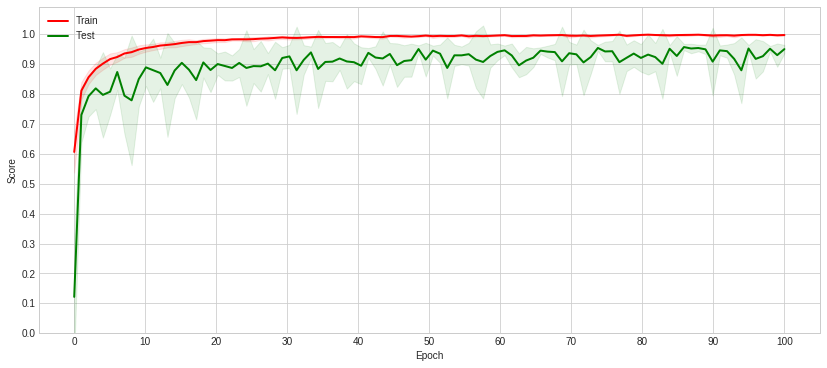

In [5]:
plot_mean_acc(hist)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

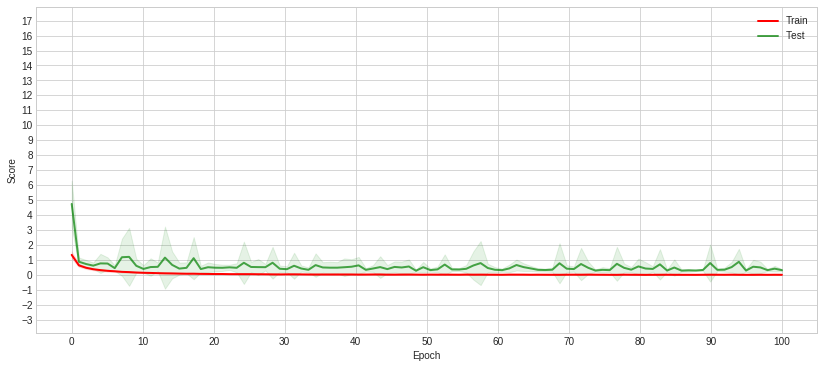

In [7]:
plot_mean_loss(hist)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-13, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

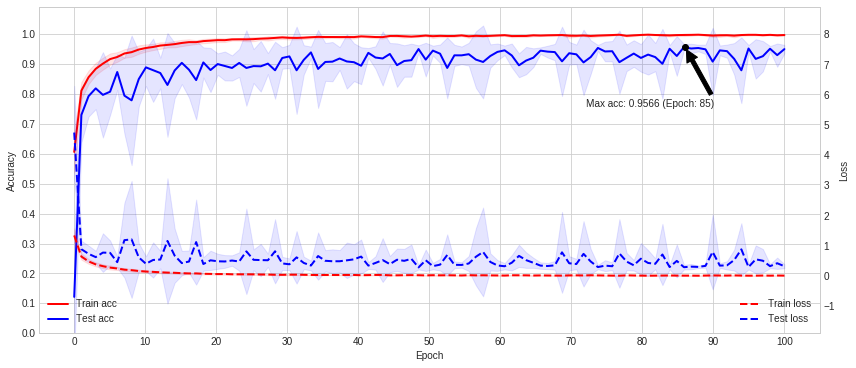

In [9]:
plot_mean(hist)